In [1]:
import io
import os
import math
import sys
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D projection of plot
%matplotlib inline

import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.


2.2.5
1.15.0


Quick look at data:

Orientation: [ 0.         55.38461538 55.38461538]

1.) Voxels
Min: 0.0014597149565815926, Max: 0.5, Shape: (9, 9, 9, 1)


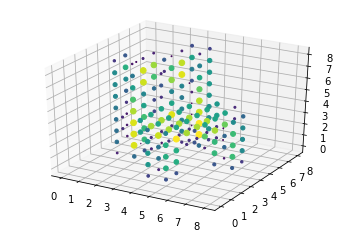

2.) PCA
[[ 0.74555224  0.26463488  0.03561563]
 [ 0.26463488  1.17046809 -0.39254314]
 [ 0.03561563 -0.39254314  0.74228776]]
3.) planar projection
Min: -1.4173123836517334, Max: 1.3068912029266357, Shape: (128, 128, 1)


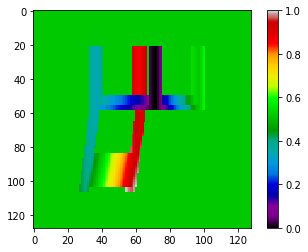

4.) cylindrical projection
Min: 0.0, Max: 1.4548304080963135, Shape: (128, 128, 1)


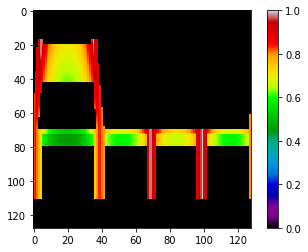

5.) spherical projection
Min: 0.0, Max: 2.203505277633667, Shape: (128, 128, 1)


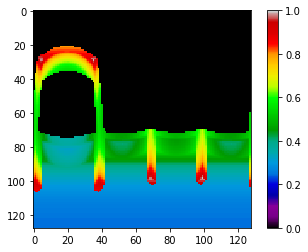

In [2]:
# Utility functions: 
# Plot Voxels as a point cloud:
def plot_voxels(nvoxels, resolution=9, point_size=10, alpha=1):
    xs = list()
    ys = list()
    zs = list()
    sizes = list()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xs.append(x)
                ys.append(y)
                zs.append(z)
                sizes.append(point_size*(nvoxels.max() - nvoxels[x, z, y, 0] ))
    ax.scatter(xs, ys, zs, s=sizes, c=sizes, alpha=alpha)
    
# Store Numpy array in SqLite database:
def adapt_array(arr):
    """
    Save Numpy array to SqLite.
    Source:
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    """ 
    Load Numpy array from Sqlite.
    Source:
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

# Load database:
data_path = os.path.join("data", "data.db")
data_test_path = os.path.join("data", "data_test.db")
conn = sqlite3.connect(data_path, isolation_level=None, detect_types=sqlite3.PARSE_DECLTYPES)
query = "SELECT orientation FROM data WHERE id = 33"
cursor = conn.cursor()
cursor.execute(query)
print("Orientation: {}\n".format(cursor.fetchall()[0][0]))

query = "SELECT orientation, voxels, pca, plane, cylinder, sphere FROM data WHERE id = 31"
cursor = conn.cursor()
cursor.execute(query)
sample = cursor.fetchall()
orientation, voxels, pca, plane, cylinder, sphere = sample[0]
nvoxels = np.asarray(voxels).reshape((9, 9, 9, 1))

# Preview of different 3D object representations:
print("1.) Voxels")
print("Min: {}, Max: {}, Shape: {}".format(nvoxels.min(), nvoxels.max(), nvoxels.shape))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_voxels(nvoxels, resolution=9, point_size=70)
plt.show()

print("2.) PCA")
print(pca)

print("3.) planar projection")
print("Min: {}, Max: {}, Shape: {}".format(plane.min(), plane.max(), plane.shape))
plane = plane.reshape(128, 128)
plane -= plane.min()
plane /= plane.max()
plt.imshow(plane,cmap='nipy_spectral')
plt.colorbar()
plt.show()

print("4.) cylindrical projection")
print("Min: {}, Max: {}, Shape: {}".format(cylinder.min(), cylinder.max(), cylinder.shape))
cylinder = cylinder.reshape(128, 128)
cylinder -= cylinder.min()
cylinder /= cylinder.max()
plt.imshow(cylinder,cmap='nipy_spectral')
plt.colorbar()
plt.show()

print("5.) spherical projection")
print("Min: {}, Max: {}, Shape: {}".format(sphere.min(), sphere.max(), sphere.shape))
sphere = sphere.reshape(128, 128)
sphere -= sphere.min()
sphere /= sphere.max()
plt.imshow(sphere,cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [3]:
import io
import math

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.utils import to_categorical
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

Generator for data from sqlite:

In [4]:
# Idea for angle data representation:
# https://stats.stackexchange.com/questions/218407/encoding-angle-data-for-neural-network - Lyndon White

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras from SQLite database'
    def __init__(self, path, num_features, end_index=None, start_index=1, batch_size=25,
                 shuffle=True, dim=(9, 9, 9), column="voxels"):
        'Initialization'
        sqlite3.register_adapter(np.ndarray, adapt_array)
        sqlite3.register_converter("array", convert_array)
        self.path = path
        self.dim = dim
        self.db = sqlite3.connect(self.path, detect_types=sqlite3.PARSE_DECLTYPES, check_same_thread=False)
        self.db_cursor = self.db.cursor()
        self.N = num_features
        self.start_index = start_index
        if end_index is None:
            end_index =  num_features + 1
        self.end_index = end_index
        self.column = column
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.sample_index = np.arange(self.start_index, self.end_index)
        self.on_epoch_end()
        self.db.close()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.N / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data - generates indexes of the batch'
        samples_batch = np.arange((index) * self.batch_size, (index+1) * self.batch_size)

        # Generate data
        x, y = self.__data_generation(samples_batch)

        return  x, y

    def on_epoch_end(self):
        'Shuffle indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.sample_index)

    def __data_generation(self, samples_batch):
        'Generates data containing batch_size samples' 
        x = np.empty((self.batch_size, *self.dim))
        y = np.empty(shape=(self.batch_size, 6))
        inds = self.sample_index[samples_batch]
        sqlite3.register_adapter(np.ndarray, adapt_array)
        sqlite3.register_converter("array", convert_array)
        db = sqlite3.connect(self.path, detect_types=sqlite3.PARSE_DECLTYPES)
        db_cursor = db.cursor()
        sql_query = "SELECT orientation, {column} FROM data WHERE id in ({index})".\
            format(column=self.column, index=','.join(str(ind) for ind in inds))
        db_cursor.execute(sql_query)
        for i in range(self.batch_size):
            line = db_cursor.fetchone()
            y[i] = np.asarray([[np.sin(math.radians(angle)), np.cos(math.radians(angle))] for angle in line[0]]).reshape(6)
            x_tmp = line[1].reshape(self.dim)
            x_tmp -= x_tmp.min()
            x_tmp /= x_tmp.max()
            x[i, :] = x_tmp
        return x, y

In [5]:
# Loss function 
# thanks to https://stackoverflow.com/questions/46355068/keras-loss-function-for-360-degree-prediction/46357303#46357303 - kmh

import keras.backend as K
import tensorflow as tf

def rmse_360_2(y_true, y_pred):
  return K.mean(K.abs(tf.atan2(K.sin(y_true - y_pred), K.cos(y_true - y_pred))))
        

1.) Voxels. Dense network and CNN

In [6]:
voxel_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(9, 9, 9, 1), batch_size=32, column="voxels")
voxel_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(9, 9, 9, 1), batch_size=32, column="voxels")

Just quick peek on data from generator, to be sure that it works:

31


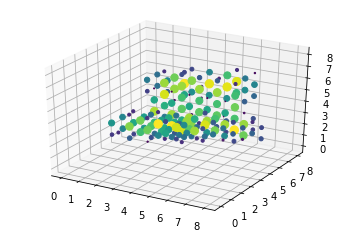

In [7]:
print(len(voxel_validation_generator))
v = voxel_validation_generator[11][0][0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_voxels(v, resolution=9, point_size=70)

In [8]:
#General callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)

a) Simple dense neural network

In [9]:
model_dense_voxel_mse = Sequential()
model_dense_voxel_mse.add(Flatten(input_shape=(9, 9, 9, 1))) 
model_dense_voxel_mse.add(Dense(1024,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel_mse.add(Dense(256,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel_mse.add(Dense(32,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel_mse.add(Dense(6, activation="tanh"))

W1217 06:55:16.684188 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1217 06:55:16.686235 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1217 06:55:16.694249 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [10]:
model_dense_voxel_mse.compile(optimizer = 'adam', 
                          loss = 'mse',
                          metrics = ['mse', 'mae', 'mape', 'cosine'])
model_dense_voxel_mse.summary()

W1217 06:55:16.742870 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 729)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              747520    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 1,018,342
Trainable params: 1,018,342
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Callbacks for dense
checkpoint_dense_voxel = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_dense_voxel_mse.hdf5', verbose=1, save_best_only=True)
store_result_dense_voxel = keras.callbacks.CSVLogger("results_dense_voxel_mse.csv", separator=',', append=False)

In [12]:
# Using workers=2, use_multiprocessing=True sometimes resulted in freeze
result_dense_voxel = model_dense_voxel_mse.fit_generator(voxel_training_generator, verbose=1, validation_data=voxel_validation_generator,
                                                     epochs=500, 
                                                     callbacks=[early_stopping, checkpoint_dense_voxel, store_result_dense_voxel, reduce_lr])
model_dense_voxel_mse.save(os.path.join("models", 'dense_voxel_mse.model'))

W1217 06:55:16.871089 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1217 06:55:17.021211 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1217 06:55:17.086324 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3005: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1217 06:55:17.149292 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1217 06:55:17.152775 14060354902

Epoch 1/500


W1217 06:55:17.645564 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:223: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



421/421 [==============================] - 9s 22ms/step - loss: 0.5632 - mean_squared_error: 0.4952 - mean_absolute_error: 0.6193 - mean_absolute_percentage_error: 7903479.9850 - cosine_proximity: -0.1680 - val_loss: 0.5312 - val_mean_squared_error: 0.4782 - val_mean_absolute_error: 0.6073 - val_mean_absolute_percentage_error: 7490440.2661 - val_cosine_proximity: -0.1656

Epoch 00001: val_loss improved from inf to 0.53120, saving model to /tmp/weights_dense_voxel_mse.hdf5
Epoch 2/500
421/421 [==============================] - 8s 19ms/step - loss: 0.4939 - mean_squared_error: 0.4493 - mean_absolute_error: 0.5856 - mean_absolute_percentage_error: 7983045.8681 - cosine_proximity: -0.2906 - val_loss: 0.4813 - val_mean_squared_error: 0.4438 - val_mean_absolute_error: 0.5798 - val_mean_absolute_percentage_error: 5302883.5565 - val_cosine_proximity: -0.3082

Epoch 00002: val_loss improved from 0.53120 to 0.48126, saving model to /tmp/weights_dense_voxel_mse.hdf5
Epoch 3/500
421/421 [=========


Epoch 00035: val_loss did not improve from 0.29897
Epoch 36/500
421/421 [==============================] - 8s 20ms/step - loss: 0.2968 - mean_squared_error: 0.2833 - mean_absolute_error: 0.4143 - mean_absolute_percentage_error: 9972775.9834 - cosine_proximity: -0.6297 - val_loss: 0.2889 - val_mean_squared_error: 0.2753 - val_mean_absolute_error: 0.4048 - val_mean_absolute_percentage_error: 8969932.6734 - val_cosine_proximity: -0.6477

Epoch 00036: val_loss improved from 0.29897 to 0.28888, saving model to /tmp/weights_dense_voxel_mse.hdf5
Epoch 37/500
421/421 [==============================] - 8s 19ms/step - loss: 0.2900 - mean_squared_error: 0.2762 - mean_absolute_error: 0.4069 - mean_absolute_percentage_error: 9689080.0803 - cosine_proximity: -0.6403 - val_loss: 0.2785 - val_mean_squared_error: 0.2646 - val_mean_absolute_error: 0.3930 - val_mean_absolute_percentage_error: 8438641.8387 - val_cosine_proximity: -0.6634

Epoch 00037: val_loss improved from 0.28888 to 0.27854, saving mod


Epoch 00053: val_loss did not improve from 0.22051
Epoch 54/500
421/421 [==============================] - 8s 19ms/step - loss: 0.2310 - mean_squared_error: 0.2127 - mean_absolute_error: 0.3448 - mean_absolute_percentage_error: 10957834.9186 - cosine_proximity: -0.7416 - val_loss: 0.2245 - val_mean_squared_error: 0.2062 - val_mean_absolute_error: 0.3382 - val_mean_absolute_percentage_error: 9954913.5645 - val_cosine_proximity: -0.7529

Epoch 00054: val_loss did not improve from 0.22051
Epoch 55/500
421/421 [==============================] - 8s 19ms/step - loss: 0.2314 - mean_squared_error: 0.2129 - mean_absolute_error: 0.3447 - mean_absolute_percentage_error: 10869278.4543 - cosine_proximity: -0.7408 - val_loss: 0.2357 - val_mean_squared_error: 0.2172 - val_mean_absolute_error: 0.3483 - val_mean_absolute_percentage_error: 10223240.7581 - val_cosine_proximity: -0.7407

Epoch 00055: val_loss did not improve from 0.22051
Epoch 56/500
421/421 [==============================] - 8s 20ms/ste

421/421 [==============================] - 8s 19ms/step - loss: 0.1716 - mean_squared_error: 0.1481 - mean_absolute_error: 0.2794 - mean_absolute_percentage_error: 11780161.4871 - cosine_proximity: -0.8334 - val_loss: 0.1980 - val_mean_squared_error: 0.1744 - val_mean_absolute_error: 0.3048 - val_mean_absolute_percentage_error: 11080524.1129 - val_cosine_proximity: -0.7978

Epoch 00090: val_loss did not improve from 0.16499
Epoch 91/500
421/421 [==============================] - 8s 19ms/step - loss: 0.1727 - mean_squared_error: 0.1491 - mean_absolute_error: 0.2806 - mean_absolute_percentage_error: 12006983.1345 - cosine_proximity: -0.8321 - val_loss: 0.1848 - val_mean_squared_error: 0.1611 - val_mean_absolute_error: 0.2936 - val_mean_absolute_percentage_error: 12167822.1452 - val_cosine_proximity: -0.8175

Epoch 00091: val_loss did not improve from 0.16499
Epoch 92/500
421/421 [==============================] - 8s 19ms/step - loss: 0.1740 - mean_squared_error: 0.1503 - mean_absolute_er

421/421 [==============================] - 8s 19ms/step - loss: 0.1447 - mean_squared_error: 0.1187 - mean_absolute_error: 0.2491 - mean_absolute_percentage_error: 12030025.6173 - cosine_proximity: -0.8726 - val_loss: 0.1371 - val_mean_squared_error: 0.1110 - val_mean_absolute_error: 0.2403 - val_mean_absolute_percentage_error: 11463528.8710 - val_cosine_proximity: -0.8819

Epoch 00126: val_loss did not improve from 0.12834
Epoch 127/500
421/421 [==============================] - 8s 20ms/step - loss: 0.1486 - mean_squared_error: 0.1225 - mean_absolute_error: 0.2524 - mean_absolute_percentage_error: 12067543.4276 - cosine_proximity: -0.8679 - val_loss: 0.1333 - val_mean_squared_error: 0.1072 - val_mean_absolute_error: 0.2368 - val_mean_absolute_percentage_error: 11200155.2903 - val_cosine_proximity: -0.8869

Epoch 00127: val_loss did not improve from 0.12834
Epoch 128/500
421/421 [==============================] - 8s 20ms/step - loss: 0.1394 - mean_squared_error: 0.1132 - mean_absolute_

rmse_360_2 loss

In [13]:
model_dense_voxel = Sequential()
model_dense_voxel.add(Flatten(input_shape=(9, 9, 9, 1))) 
model_dense_voxel.add(Dense(1024,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel.add(Dense(256,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel.add(Dense(32,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel.add(Dense(6, activation="tanh"))

model_dense_voxel.compile(optimizer = 'adam', 
                          loss = rmse_360_2,
                          metrics = ['mse', 'mae', 'mape', 'cosine'])
model_dense_voxel.summary()

# Callbacks for dense
checkpoint_dense_voxel = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_dense_voxel.hdf5', verbose=1, save_best_only=True)
store_result_dense_voxel = keras.callbacks.CSVLogger("results_dense_voxel.csv", separator=',', append=False)

result_dense_voxel = model_dense_voxel.fit_generator(voxel_training_generator, verbose=1, validation_data=voxel_validation_generator,
                                                     epochs=500, 
                                                     callbacks=[early_stopping, checkpoint_dense_voxel, store_result_dense_voxel, reduce_lr])
model_dense_voxel.save('models/dense_voxel.model')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 729)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              747520    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 1,018,342
Trainable params: 1,018,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
421/421 [==============================] - 9s 20ms/step - loss: 0.6811 - mean_squared_error: 0.500

421/421 [==============================] - 8s 19ms/step - loss: 0.6191 - mean_squared_error: 0.4939 - mean_absolute_error: 0.6191 - mean_absolute_percentage_error: 1295441.4721 - cosine_proximity: -0.1111 - val_loss: 0.6261 - val_mean_squared_error: 0.5074 - val_mean_absolute_error: 0.6261 - val_mean_absolute_percentage_error: 1196408.5806 - val_cosine_proximity: -0.0039

Epoch 00034: val_loss did not improve from 0.62600
Epoch 35/500
421/421 [==============================] - 8s 19ms/step - loss: 0.6191 - mean_squared_error: 0.4941 - mean_absolute_error: 0.6191 - mean_absolute_percentage_error: 1113745.9979 - cosine_proximity: -0.1098 - val_loss: 0.6264 - val_mean_squared_error: 0.5077 - val_mean_absolute_error: 0.6264 - val_mean_absolute_percentage_error: 1138169.3054 - val_cosine_proximity: -9.1503e-04

Epoch 00035: val_loss did not improve from 0.62600
Epoch 36/500
421/421 [==============================] - 8s 19ms/step - loss: 0.6191 - mean_squared_error: 0.4939 - mean_absolute_er

b) Convolutional neural network

In [9]:
# Build convolutional neural net

model_cnn_voxels = Sequential()

model_cnn_voxels.add(Conv3D(16,(5,5,5), padding = 'same', activation = 'relu', input_shape = (9,9,9,1)))
model_cnn_voxels.add(BatchNormalization())
model_cnn_voxels.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels.add(Dropout(0.1))

model_cnn_voxels.add(Conv3D(32, (5,5,5), padding = 'same', activation = 'relu'))
model_cnn_voxels.add(BatchNormalization())
model_cnn_voxels.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels.add(Dropout(0.1))

model_cnn_voxels.add(Flatten())
model_cnn_voxels.add(Dense(128, activation = 'relu'))
model_cnn_voxels.add(Dense(6, activation="tanh"))

W1217 20:47:29.312506 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1217 20:47:29.314851 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1217 20:47:29.317094 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1217 20:47:29.378433 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

rmse_360_2 loss:

In [10]:
model_cnn_voxels.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_cnn_voxels.summary()

W1217 20:47:31.645312 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 9, 9, 9, 16)       2016      
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 9, 16)       64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 4, 4, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 4, 16)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 4, 4, 32)       64032     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 4, 32)       128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 2, 2, 32)      

In [11]:
checkpoint_cnn_voxel = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_cnn_voxel.hdf5', verbose=1, save_best_only=True)
store_result_cnn_voxel = keras.callbacks.CSVLogger("results_cnn_voxel.csv", separator=',', append=False)

In [12]:
result_cnn_voxels = model_cnn_voxels.fit_generator(generator=voxel_training_generator, validation_data=voxel_validation_generator,
                                                   epochs=500, 
                                                   callbacks=[early_stopping, checkpoint_cnn_voxel, store_result_cnn_voxel, reduce_lr, early_stopping])
model_cnn_voxels.save('models/cnn_voxel.model')

W1217 20:47:36.099558 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1217 20:47:36.204792 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1217 20:47:36.305918 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3005: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1217 20:47:36.364001 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1217 20:47:36.373395 14016594073

Epoch 1/500


W1217 20:47:36.514672 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1217 20:47:36.518716 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:216: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W1217 20:47:37.124390 140165940733760 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:223: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



421/421 [==============================] - 12s 28ms/step - loss: 0.6901 - mean_squared_error: 0.7584 - mean_absolute_error: 0.6901 - mean_absolute_percentage_error: 24850747.2708 - cosine_proximity: -0.1762 - val_loss: 0.5804 - val_mean_squared_error: 0.5036 - val_mean_absolute_error: 0.5804 - val_mean_absolute_percentage_error: 14455568.7097 - val_cosine_proximity: -0.2487

Epoch 00001: val_loss improved from inf to 0.58044, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 2/500
421/421 [==============================] - 8s 19ms/step - loss: 0.5415 - mean_squared_error: 0.4746 - mean_absolute_error: 0.5415 - mean_absolute_percentage_error: 12323561.9305 - cosine_proximity: -0.3366 - val_loss: 0.5649 - val_mean_squared_error: 0.5155 - val_mean_absolute_error: 0.5649 - val_mean_absolute_percentage_error: 11781236.4677 - val_cosine_proximity: -0.2813

Epoch 00002: val_loss improved from 0.58044 to 0.56488, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 3/500
421/421 [================

421/421 [==============================] - 8s 20ms/step - loss: 0.1560 - mean_squared_error: 0.0614 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 8945370.1583 - cosine_proximity: -0.9366 - val_loss: 0.1324 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1324 - val_mean_absolute_percentage_error: 8371705.0806 - val_cosine_proximity: -0.9555

Epoch 00018: val_loss improved from 0.13797 to 0.13239, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 19/500
421/421 [==============================] - 8s 20ms/step - loss: 0.1513 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 8474074.6162 - cosine_proximity: -0.9410 - val_loss: 0.1306 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1306 - val_mean_absolute_percentage_error: 6968071.7944 - val_cosine_proximity: -0.9560

Epoch 00019: val_loss improved from 0.13239 to 0.13061, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 20/500
421/421 [===============


Epoch 00035: val_loss did not improve from 0.08336
Epoch 36/500
421/421 [==============================] - 8s 19ms/step - loss: 0.1129 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1129 - mean_absolute_percentage_error: 6254522.1749 - cosine_proximity: -0.9723 - val_loss: 0.0889 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0889 - val_mean_absolute_percentage_error: 4800763.7540 - val_cosine_proximity: -0.9830

Epoch 00036: val_loss did not improve from 0.08336
Epoch 37/500
421/421 [==============================] - 8s 20ms/step - loss: 0.1120 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1120 - mean_absolute_percentage_error: 6084549.3077 - cosine_proximity: -0.9728 - val_loss: 0.0883 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0883 - val_mean_absolute_percentage_error: 4891407.0232 - val_cosine_proximity: -0.9852

Epoch 00037: val_loss did not improve from 0.08336
Epoch 38/500
421/421 [==============================] - 8s 20ms/step -

421/421 [==============================] - 9s 21ms/step - loss: 0.0982 - mean_squared_error: 0.0222 - mean_absolute_error: 0.0982 - mean_absolute_percentage_error: 5076454.2230 - cosine_proximity: -0.9799 - val_loss: 0.0712 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0712 - val_mean_absolute_percentage_error: 3251729.1935 - val_cosine_proximity: -0.9917

Epoch 00054: val_loss improved from 0.07356 to 0.07123, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 55/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0975 - mean_squared_error: 0.0220 - mean_absolute_error: 0.0975 - mean_absolute_percentage_error: 4984201.8441 - cosine_proximity: -0.9800 - val_loss: 0.0723 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0723 - val_mean_absolute_percentage_error: 3445237.8851 - val_cosine_proximity: -0.9910

Epoch 00055: val_loss did not improve from 0.07123
Epoch 56/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0963 - 

421/421 [==============================] - 9s 21ms/step - loss: 0.0892 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0892 - mean_absolute_percentage_error: 4381136.8109 - cosine_proximity: -0.9838 - val_loss: 0.0667 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0667 - val_mean_absolute_percentage_error: 2814658.0988 - val_cosine_proximity: -0.9936

Epoch 00072: val_loss did not improve from 0.06470
Epoch 73/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0892 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0892 - mean_absolute_percentage_error: 4391288.5808 - cosine_proximity: -0.9837 - val_loss: 0.0663 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0663 - val_mean_absolute_percentage_error: 3231450.4254 - val_cosine_proximity: -0.9925

Epoch 00073: val_loss did not improve from 0.06470
Epoch 74/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0878 - mean_squared_error: 0.0176 - mean_absolute_error:

MSE loss:

In [18]:
model_cnn_voxels_mse = Sequential()

model_cnn_voxels_mse.add(Conv3D(16,(5,5,5), padding = 'same', activation = 'relu', input_shape = (9,9,9,1)))
model_cnn_voxels_mse.add(BatchNormalization())
model_cnn_voxels_mse.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels_mse.add(Dropout(0.1))

model_cnn_voxels_mse.add(Conv3D(32, (5,5,5), padding = 'same', activation = 'relu'))
model_cnn_voxels_mse.add(BatchNormalization())
model_cnn_voxels_mse.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels_mse.add(Dropout(0.1))

model_cnn_voxels_mse.add(Flatten())
model_cnn_voxels_mse.add(Dense(128, activation = 'relu'))
model_cnn_voxels_mse.add(Dense(6, activation="tanh"))

model_cnn_voxels_mse.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_cnn_voxels_mse.summary()
checkpoint_cnn_voxel_mse = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_cnn_voxel_mse.hdf5', verbose=1, save_best_only=True)
store_result_cnn_voxel_mse = keras.callbacks.CSVLogger("results_cnn_voxel_mse.csv", separator=',', append=False)
result_cnn_voxels_mse = model_cnn_voxels_mse.fit_generator(generator=voxel_training_generator, validation_data=voxel_validation_generator,
                                                       epochs=500, 
                                                       callbacks=[early_stopping, checkpoint_cnn_voxel_mse, store_result_cnn_voxel_mse, reduce_lr])
model_cnn_voxels_mse.save('models/cnn_voxel_mse.model')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 9, 9, 9, 16)       2016      
_________________________________________________________________
batch_normalization_5 (Batch (None, 9, 9, 9, 16)       64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 4, 4, 4, 16)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 4, 16)       0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 4, 4, 4, 32)       64032     
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 4, 32)       128       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 2, 2, 2, 32)      

421/421 [==============================] - 8s 20ms/step - loss: 0.0614 - mean_squared_error: 0.0614 - mean_absolute_error: 0.1757 - mean_absolute_percentage_error: 11377058.8836 - cosine_proximity: -0.9397 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1427 - val_mean_absolute_percentage_error: 8327899.6290 - val_cosine_proximity: -0.9645

Epoch 00014: val_loss improved from 0.04693 to 0.03898, saving model to /tmp/weights_cnn_voxel_mse.hdf5
Epoch 15/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1672 - mean_absolute_percentage_error: 10887981.1363 - cosine_proximity: -0.9459 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1294 - val_mean_absolute_percentage_error: 8308111.6129 - val_cosine_proximity: -0.9723

Epoch 00015: val_loss improved from 0.03898 to 0.03089, saving model to /tmp/weights_cnn_voxel_mse.hdf5
Epoch 16/500
421/421 [=====


Epoch 00031: val_loss did not improve from 0.01643
Epoch 32/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1227 - mean_absolute_percentage_error: 7846647.8530 - cosine_proximity: -0.9734 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0906 - val_mean_absolute_percentage_error: 5505033.9798 - val_cosine_proximity: -0.9873

Epoch 00032: val_loss improved from 0.01643 to 0.01502, saving model to /tmp/weights_cnn_voxel_mse.hdf5
Epoch 33/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1185 - mean_absolute_percentage_error: 7693758.4290 - cosine_proximity: -0.9758 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0956 - val_mean_absolute_percentage_error: 6047217.8629 - val_cosine_proximity: -0.9867

Epoch 00033: val_loss did not improve from 0.01502
Epoch 34/500
421/


Epoch 00049: val_loss improved from 0.01096 to 0.01052, saving model to /tmp/weights_cnn_voxel_mse.hdf5
Epoch 50/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1013 - mean_absolute_percentage_error: 6423358.6924 - cosine_proximity: -0.9830 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0892 - val_mean_absolute_percentage_error: 4973698.6573 - val_cosine_proximity: -0.9881

Epoch 00050: val_loss did not improve from 0.01052
Epoch 51/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1028 - mean_absolute_percentage_error: 6608917.2031 - cosine_proximity: -0.9824 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0908 - val_mean_absolute_percentage_error: 5468440.8790 - val_cosine_proximity: -0.9870

Epoch 00051: val_loss did not improve from 0.01052
Epoch 52/500
421/

421/421 [==============================] - 8s 20ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0944 - mean_absolute_percentage_error: 5795208.3959 - cosine_proximity: -0.9849 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0671 - val_mean_absolute_percentage_error: 3347573.7056 - val_cosine_proximity: -0.9941

Epoch 00068: val_loss improved from 0.00824 to 0.00793, saving model to /tmp/weights_cnn_voxel_mse.hdf5
Epoch 69/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0908 - mean_absolute_percentage_error: 5720220.5094 - cosine_proximity: -0.9866 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0717 - val_mean_absolute_percentage_error: 3417330.9274 - val_cosine_proximity: -0.9929

Epoch 00069: val_loss did not improve from 0.00793
Epoch 70/500
421/421 [==============================] - 8s 20ms/step - loss: 0.016

421/421 [==============================] - 8s 20ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0850 - mean_absolute_percentage_error: 5245517.2711 - cosine_proximity: -0.9884 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0620 - val_mean_absolute_percentage_error: 3329002.5121 - val_cosine_proximity: -0.9944

Epoch 00086: val_loss improved from 0.00699 to 0.00691, saving model to /tmp/weights_cnn_voxel_mse.hdf5
Epoch 87/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0852 - mean_absolute_percentage_error: 5209556.0368 - cosine_proximity: -0.9883 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0622 - val_mean_absolute_percentage_error: 3241033.0202 - val_cosine_proximity: -0.9949

Epoch 00087: val_loss improved from 0.00691 to 0.00677, saving model to /tmp/weights_cnn_voxel_mse.hdf5
Epoch 88/500
421/421 [=======

421/421 [==============================] - 8s 20ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0808 - mean_absolute_percentage_error: 4850077.0618 - cosine_proximity: -0.9896 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0605 - val_mean_absolute_percentage_error: 3074213.3952 - val_cosine_proximity: -0.9952

Epoch 00104: val_loss did not improve from 0.00629
Epoch 105/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0807 - mean_absolute_percentage_error: 4859254.6222 - cosine_proximity: -0.9895 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0638 - val_mean_absolute_percentage_error: 3615333.6190 - val_cosine_proximity: -0.9939

Epoch 00105: val_loss did not improve from 0.00629
Epoch 106/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_erro

2.) Principal component analysis

In [19]:
pca_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(3, 3, 1), batch_size=32, column="pca")
pca_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(3, 3, 1), batch_size=32, column="pca")

In [20]:
model_pca = Sequential()
model_pca.add(Flatten(input_shape=(3, 3, 1))) 
model_pca.add(Dense(512,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_pca.add(Dense(64,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_pca.add(Dense(6, activation="tanh"))

In [21]:
model_pca.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_pca.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               5120      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 390       
Total params: 38,342
Trainable params: 38,342
Non-trainable params: 0
_________________________________________________________________


In [22]:
checkpoint_pca = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_pca.hdf5', verbose=1, save_best_only=True)
store_result_pca = keras.callbacks.CSVLogger("results_pca.csv", separator=',', append=False)

In [23]:
result_pca = model_pca.fit_generator(pca_training_generator, verbose=1, validation_data=pca_validation_generator,
                                           epochs=500, 
                                           callbacks=[early_stopping, checkpoint_pca, store_result_pca, reduce_lr])
model_pca.save('models/pca.model')

Epoch 1/500
421/421 [==============================] - 8s 19ms/step - loss: 0.6247 - mean_squared_error: 0.4971 - mean_absolute_error: 0.6196 - mean_absolute_percentage_error: 4253561.5901 - cosine_proximity: -0.1109 - val_loss: 0.6288 - val_mean_squared_error: 0.5217 - val_mean_absolute_error: 0.6257 - val_mean_absolute_percentage_error: 6672752.5449 - val_cosine_proximity: -0.0414

Epoch 00001: val_loss improved from inf to 0.62882, saving model to /tmp/weights_pca.hdf5
Epoch 2/500
421/421 [==============================] - 7s 17ms/step - loss: 0.6164 - mean_squared_error: 0.5075 - mean_absolute_error: 0.6136 - mean_absolute_percentage_error: 4474984.1539 - cosine_proximity: -0.1160 - val_loss: 0.6290 - val_mean_squared_error: 0.5407 - val_mean_absolute_error: 0.6262 - val_mean_absolute_percentage_error: 2353359.0101 - val_cosine_proximity: -0.0189

Epoch 00002: val_loss did not improve from 0.62882
Epoch 3/500
421/421 [==============================] - 8s 18ms/step - loss: 0.6111 - 


Epoch 00018: val_loss did not improve from 0.61555
Epoch 19/500
421/421 [==============================] - 8s 18ms/step - loss: 0.5982 - mean_squared_error: 0.5749 - mean_absolute_error: 0.5940 - mean_absolute_percentage_error: 2226452.2036 - cosine_proximity: -0.1323 - val_loss: 0.6099 - val_mean_squared_error: 0.5954 - val_mean_absolute_error: 0.6058 - val_mean_absolute_percentage_error: 2007073.0897 - val_cosine_proximity: -0.0860

Epoch 00019: val_loss improved from 0.61555 to 0.60995, saving model to /tmp/weights_pca.hdf5
Epoch 20/500
421/421 [==============================] - 8s 18ms/step - loss: 0.5982 - mean_squared_error: 0.5773 - mean_absolute_error: 0.5940 - mean_absolute_percentage_error: 2239223.0146 - cosine_proximity: -0.1315 - val_loss: 0.6164 - val_mean_squared_error: 0.6168 - val_mean_absolute_error: 0.6122 - val_mean_absolute_percentage_error: 1925591.1794 - val_cosine_proximity: -0.0649

Epoch 00020: val_loss did not improve from 0.60995
Epoch 21/500
421/421 [=====


Epoch 00036: val_loss did not improve from 0.59487
Epoch 37/500
421/421 [==============================] - 8s 18ms/step - loss: 0.5939 - mean_squared_error: 0.5896 - mean_absolute_error: 0.5891 - mean_absolute_percentage_error: 2213419.2499 - cosine_proximity: -0.1384 - val_loss: 0.5959 - val_mean_squared_error: 0.5976 - val_mean_absolute_error: 0.5910 - val_mean_absolute_percentage_error: 1794930.2278 - val_cosine_proximity: -0.1200

Epoch 00037: val_loss did not improve from 0.59487
Epoch 38/500
421/421 [==============================] - 8s 18ms/step - loss: 0.5938 - mean_squared_error: 0.5894 - mean_absolute_error: 0.5890 - mean_absolute_percentage_error: 2180085.8737 - cosine_proximity: -0.1390 - val_loss: 0.5998 - val_mean_squared_error: 0.6126 - val_mean_absolute_error: 0.5949 - val_mean_absolute_percentage_error: 2269387.9032 - val_cosine_proximity: -0.1138

Epoch 00038: val_loss did not improve from 0.59487
Epoch 39/500
421/421 [==============================] - 8s 18ms/step -


Epoch 00073: val_loss improved from 0.58710 to 0.58679, saving model to /tmp/weights_pca.hdf5
Epoch 74/500
421/421 [==============================] - 8s 18ms/step - loss: 0.5871 - mean_squared_error: 0.5847 - mean_absolute_error: 0.5804 - mean_absolute_percentage_error: 2115484.3172 - cosine_proximity: -0.1572 - val_loss: 0.5899 - val_mean_squared_error: 0.5925 - val_mean_absolute_error: 0.5832 - val_mean_absolute_percentage_error: 1760608.9919 - val_cosine_proximity: -0.1363

Epoch 00074: val_loss did not improve from 0.58679
Epoch 75/500
421/421 [==============================] - 8s 18ms/step - loss: 0.5872 - mean_squared_error: 0.5850 - mean_absolute_error: 0.5805 - mean_absolute_percentage_error: 2142595.0240 - cosine_proximity: -0.1580 - val_loss: 0.5892 - val_mean_squared_error: 0.5877 - val_mean_absolute_error: 0.5825 - val_mean_absolute_percentage_error: 1735964.9899 - val_cosine_proximity: -0.1384

Epoch 00075: val_loss did not improve from 0.58679
Epoch 76/500
421/421 [=====

421/421 [==============================] - 8s 18ms/step - loss: 0.5807 - mean_squared_error: 0.5768 - mean_absolute_error: 0.5725 - mean_absolute_percentage_error: 2205313.8842 - cosine_proximity: -0.1761 - val_loss: 0.5798 - val_mean_squared_error: 0.5884 - val_mean_absolute_error: 0.5717 - val_mean_absolute_percentage_error: 2052612.6290 - val_cosine_proximity: -0.1666

Epoch 00110: val_loss did not improve from 0.57720
Epoch 111/500
421/421 [==============================] - 8s 18ms/step - loss: 0.5803 - mean_squared_error: 0.5760 - mean_absolute_error: 0.5721 - mean_absolute_percentage_error: 2152924.4636 - cosine_proximity: -0.1761 - val_loss: 0.5808 - val_mean_squared_error: 0.6005 - val_mean_absolute_error: 0.5725 - val_mean_absolute_percentage_error: 2902584.2258 - val_cosine_proximity: -0.1612

Epoch 00111: val_loss did not improve from 0.57720
Epoch 112/500
421/421 [==============================] - 8s 18ms/step - loss: 0.5799 - mean_squared_error: 0.5759 - mean_absolute_erro

3.) Projection on plane

In [24]:
plane_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(128, 128, 1), batch_size=32, column="plane")
plane_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=32, column="plane")

In [25]:
model_plane = Sequential()

model_plane.add(Conv2D(16,(5,5), padding = 'same', activation = 'relu', input_shape = (128,128,1)))
model_plane.add(BatchNormalization())
model_plane.add(MaxPooling2D(pool_size = (2,2)))
model_plane.add(Dropout(0.1))

model_plane.add(Conv2D(32, (5,5), padding = 'same', activation = 'relu'))
model_plane.add(BatchNormalization())
model_plane.add(MaxPooling2D(pool_size = (2,2)))
model_plane.add(Dropout(0.1))

model_plane.add(Flatten())
model_plane.add(Dense(128, activation = 'relu'))
model_plane.add(Dense(6, activation="tanh"))

W1217 07:53:04.438677 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W1217 07:53:04.478622 140603549026112 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [26]:
model_plane.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_plane.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      416       
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)       

In [27]:
checkpoint_plane = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_cnn_plane.hdf5', verbose=1, save_best_only=True)
store_result_plane = keras.callbacks.CSVLogger("results_cnn_plane.csv", separator=',', append=False)

In [28]:
result_plane = model_plane.fit_generator(plane_training_generator, verbose=1, validation_data=plane_validation_generator,
                                                 epochs=500, 
                                                 callbacks=[early_stopping, checkpoint_plane, store_result_plane, reduce_lr])
model_plane.save('models/cnn_plane.model')

Epoch 1/500
421/421 [==============================] - 12s 29ms/step - loss: 0.9484 - mean_squared_error: 1.3967 - mean_absolute_error: 0.9484 - mean_absolute_percentage_error: 55540657.3895 - cosine_proximity: -0.0721 - val_loss: 0.8932 - val_mean_squared_error: 1.2864 - val_mean_absolute_error: 0.8932 - val_mean_absolute_percentage_error: 52419551.7419 - val_cosine_proximity: -0.1510

Epoch 00001: val_loss improved from inf to 0.89321, saving model to /tmp/weights_cnn_plane.hdf5
Epoch 2/500
421/421 [==============================] - 10s 25ms/step - loss: 0.9483 - mean_squared_error: 1.3966 - mean_absolute_error: 0.9483 - mean_absolute_percentage_error: 55572252.2090 - cosine_proximity: -0.0731 - val_loss: 0.8953 - val_mean_squared_error: 1.2907 - val_mean_absolute_error: 0.8953 - val_mean_absolute_percentage_error: 51579498.5806 - val_cosine_proximity: -0.1480

Epoch 00002: val_loss did not improve from 0.89321
Epoch 3/500
421/421 [==============================] - 10s 24ms/step - lo

b) Dense network

In [29]:
checkpoint_dense_plane = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_dense_plane.hdf5', verbose=1, save_best_only=True)
store_result_dense_plane = keras.callbacks.CSVLogger("results_dense_plane.csv", separator=',', append=False)

model_dense_plane = Sequential()
model_dense_plane.add(Flatten(input_shape=(128, 128, 1))) 
model_dense_plane.add(Dense(2048,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_plane.add(Dense(512,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_plane.add(Dense(64,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_plane.add(Dense(6, activation="tanh"))

model_dense_plane.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])

result_dense_plane = model_dense_plane.fit_generator(plane_training_generator, verbose=1, validation_data=plane_validation_generator,
                                                 epochs=500, 
                                                 callbacks=[early_stopping, checkpoint_dense_plane, store_result_dense_plane, reduce_lr])
model_dense_plane.save('models/dense_plane.model')

Epoch 1/500
421/421 [==============================] - 20s 47ms/step - loss: 1.1396 - mean_squared_error: 1.4878 - mean_absolute_error: 0.9942 - mean_absolute_percentage_error: 55468300.2138 - cosine_proximity: -0.0072 - val_loss: 1.1468 - val_mean_squared_error: 1.7087 - val_mean_absolute_error: 1.1043 - val_mean_absolute_percentage_error: 52587595.7419 - val_cosine_proximity: 0.1476

Epoch 00001: val_loss improved from inf to 1.14680, saving model to /tmp/weights_dense_plane.hdf5
Epoch 2/500
421/421 [==============================] - 18s 43ms/step - loss: 1.0455 - mean_squared_error: 1.5518 - mean_absolute_error: 1.0259 - mean_absolute_percentage_error: 55521810.7834 - cosine_proximity: 0.0366 - val_loss: 1.1136 - val_mean_squared_error: 1.7117 - val_mean_absolute_error: 1.1059 - val_mean_absolute_percentage_error: 52755606.7097 - val_cosine_proximity: 0.1497

Epoch 00002: val_loss improved from 1.14680 to 1.11360, saving model to /tmp/weights_dense_plane.hdf5
Epoch 3/500
421/421 [==


Epoch 00018: val_loss did not improve from 0.62613
Epoch 19/500
421/421 [==============================] - 18s 43ms/step - loss: 0.6191 - mean_squared_error: 0.4935 - mean_absolute_error: 0.6191 - mean_absolute_percentage_error: 2244791.0656 - cosine_proximity: -0.1156 - val_loss: 0.6269 - val_mean_squared_error: 0.5083 - val_mean_absolute_error: 0.6269 - val_mean_absolute_percentage_error: 2040570.1351 - val_cosine_proximity: -0.0051

Epoch 00019: val_loss did not improve from 0.62613
Epoch 20/500
421/421 [==============================] - 18s 43ms/step - loss: 0.6192 - mean_squared_error: 0.4936 - mean_absolute_error: 0.6192 - mean_absolute_percentage_error: 2115912.5669 - cosine_proximity: -0.1148 - val_loss: 0.6264 - val_mean_squared_error: 0.5078 - val_mean_absolute_error: 0.6264 - val_mean_absolute_percentage_error: 2110263.8710 - val_cosine_proximity: -0.0105

Epoch 00020: val_loss did not improve from 0.62613
Epoch 21/500
421/421 [==============================] - 18s 43ms/ste

4.) Projection on cylinder

In [30]:
cylinder_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(128, 128, 1), batch_size=32, column="cylinder")
cylinder_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=32, column="cylinder")

model_cylinder = Sequential()
model_cylinder.add(Conv2D(16,(5,5), padding = 'same', activation = 'relu', input_shape = (128,128,1)))
model_cylinder.add(BatchNormalization())
model_cylinder.add(MaxPooling2D(pool_size = (2,2)))
model_cylinder.add(Dropout(0.1))
model_cylinder.add(Conv2D(32, (5,5), padding = 'same', activation = 'relu'))
model_cylinder.add(BatchNormalization())
model_cylinder.add(MaxPooling2D(pool_size = (2,2)))
model_cylinder.add(Dropout(0.1))
model_cylinder.add(Flatten())
model_cylinder.add(Dense(128, activation = 'relu'))
model_cylinder.add(Dense(6, activation="tanh"))

model_cylinder.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_cylinder.summary()

checkpoint_cylinder = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_cylinder.hdf5', verbose=1, save_best_only=True)
store_result_cylinder = keras.callbacks.CSVLogger("results_cylinder.csv", separator=',', append=False)

result_cylinder = model_cylinder.fit_generator(cylinder_training_generator, verbose=1, validation_data=cylinder_validation_generator,
                                                 epochs=500, 
                                                 callbacks=[early_stopping, checkpoint_cylinder, store_result_cylinder, reduce_lr])
model_cylinder.save('models/cylinder.model')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 16)      416       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)       

421/421 [==============================] - 10s 25ms/step - loss: 0.8701 - mean_squared_error: 1.2402 - mean_absolute_error: 0.8701 - mean_absolute_percentage_error: 55522031.3444 - cosine_proximity: -0.1836 - val_loss: 1.0202 - val_mean_squared_error: 1.5405 - val_mean_absolute_error: 1.0202 - val_mean_absolute_percentage_error: 52067933.2903 - val_cosine_proximity: 0.0288

Epoch 00015: val_loss did not improve from 1.01291
Epoch 16/500
421/421 [==============================] - 10s 25ms/step - loss: 0.8750 - mean_squared_error: 1.2500 - mean_absolute_error: 0.8750 - mean_absolute_percentage_error: 55586958.8860 - cosine_proximity: -0.1767 - val_loss: 1.0114 - val_mean_squared_error: 1.5228 - val_mean_absolute_error: 1.0114 - val_mean_absolute_percentage_error: 52583521.6129 - val_cosine_proximity: 0.0163

Epoch 00016: val_loss improved from 1.01291 to 1.01142, saving model to /tmp/weights_cylinder.hdf5
Epoch 17/500
421/421 [==============================] - 10s 25ms/step - loss: 0.867

5.) Projection on sphere

In [31]:
sphere_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(128, 128, 1), batch_size=32, column="sphere")
sphere_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=32, column="sphere")

model_sphere = Sequential()
model_sphere.add(Conv2D(16,(5,5), padding = 'same', activation = 'relu', input_shape = (128,128,1)))
model_sphere.add(BatchNormalization())
model_sphere.add(MaxPooling2D(pool_size = (2,2)))
model_sphere.add(Dropout(0.1))
model_sphere.add(Conv2D(32, (5,5), padding = 'same', activation = 'relu'))
model_sphere.add(BatchNormalization())
model_sphere.add(MaxPooling2D(pool_size = (2,2)))
model_sphere.add(Dropout(0.1))
model_sphere.add(Flatten())
model_sphere.add(Dense(128, activation = 'relu'))
model_sphere.add(Dense(6, activation="tanh"))

model_sphere.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_sphere.summary()

checkpoint_sphere = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_sphere.hdf5', verbose=1, save_best_only=True)
store_result_sphere = keras.callbacks.CSVLogger("results_sphere.csv", separator=',', append=False)

result_sphere = model_sphere.fit_generator(sphere_training_generator, verbose=1, validation_data=sphere_validation_generator,
                                                 epochs=500, 
                                                 callbacks=[early_stopping, checkpoint_sphere, store_result_sphere, reduce_lr])
model_sphere.save('models/sphere.model')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 16)      416       
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)       

Example of prediction:

In [32]:
import keras
voxel_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(9, 9, 9, 1), batch_size=1, column="voxels", shuffle=False)
loaded_model = keras.models.load_model('models/cnn_voxel.model', custom_objects={'rmse_360_2': rmse_360_2})  
layer_outputs = [layer.output for layer in loaded_model.layers[:]]
multioutput_model = keras.Model(inputs=loaded_model.input, outputs=layer_outputs)
activations = multioutput_model.predict(voxel_validation_generator[5][0])

ModelVoxNet implementation, based on https://github.com/SnowMasaya/Generative-and-Discriminative-Voxel-Modeling-Keras/ made by SnowMasaya

In [33]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
# Source: https://github.com/SnowMasaya/Generative-and-Discriminative-Voxel-Modeling-Keras/blob/master/src/models/vox_net.py
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv3D, MaxPooling3D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from types import MappingProxyType


class ModelVoxNet(object):

    def __init__(self, number_class,
                 parameter_dict={
                     'input_shape': (9, 9, 9, 1),
                     'filter_size': 32,
                     'conv_kernel_size_1': 3,
                     'conv_kernel_size_2': 2,
                     'strides_1': (2, 2, 2),
                     'strides_2': (1, 1, 1),
                     'drop_out_rate_list': [0.3, 0.4, 0.5],
                     'pool_size': (2, 2, 2),
                     'units': 128
                 }
                 ):
        # init model

        default_parameter_dict = parameter_dict
        default_parameter_dict = MappingProxyType(default_parameter_dict)
        self.default_parameter_dict = default_parameter_dict

        count_dict = {}

        with tf.name_scope('Model'):
            with tf.name_scope('Inputs'):
                inputs = Input(default_parameter_dict['input_shape'])

            # convolution 1

            count_dict['Conv3D'] = 1

            with tf.name_scope('Conv3D_' + str(count_dict['Conv3D'])):
                x = Conv3D(filters=default_parameter_dict['filter_size'],
                           kernel_size=default_parameter_dict[
                               'conv_kernel_size_1'],
                           padding='valid',
                           strides=default_parameter_dict['strides_1'],
                           data_format='channels_last',
                           )(inputs)

            # Activation Leaky ReLu

            count_dict['Activation_relu'] = 1

            with tf.name_scope(
                    'Activation_relu_' + str(count_dict['Activation_relu'])):
                x = Activation('relu')(x)

            # dropout 1

            count_dict['Dropout'] = 1

            with tf.name_scope('Dropout_' + str(count_dict['Dropout'])):
                x = Dropout(
                    rate=default_parameter_dict['drop_out_rate_list'][0])(x)

            # convolution 2

            count_dict['Conv3D'] += 1

            with tf.name_scope('Conv3D_' + str(count_dict['Conv3D'])):
                x = Conv3D(filters=default_parameter_dict['filter_size'],
                           kernel_size=default_parameter_dict[
                               'conv_kernel_size_2'],
                           padding='valid',
                           strides=default_parameter_dict['strides_2'],
                           data_format='channels_last',
                           )(x)

            # Activation Leaky ReLu
            count_dict['Activation_relu'] += 1

            with tf.name_scope(
                    'Activation_relu_' + str(count_dict['Activation_relu'])):
                x = Activation('relu')(x)

            # max pool 1
            with tf.name_scope('MaxPooling3D'):
                x = MaxPooling3D(pool_size=default_parameter_dict['pool_size'],
                                 strides=None,
                                 padding='valid',
                                 data_format='channels_last',
                                 )(x)

            # dropout 2
            count_dict['Dropout'] += 1

            with tf.name_scope('Dropout_' + str(count_dict['Dropout'])):
                x = Dropout(
                    rate=default_parameter_dict['drop_out_rate_list'][2])(x)

            # dense 1 (fully connected layer)

            with tf.name_scope('Flatten'):
                x = Flatten()(x)

            count_dict['Dense'] = 1

            with tf.name_scope('Dense'):
                x = Dense(units=default_parameter_dict['units'],
                          activation='linear', )(x)

            # dropout 3
            count_dict['Dropout'] += 1

            with tf.name_scope('Dropout_' + str(count_dict['Dropout'])):
                x = Dropout(
                    rate=default_parameter_dict['drop_out_rate_list'][2])(x)

            # dense 2 (fully connected layer)

            count_dict['Dense'] += 1

            with tf.name_scope('Dense'):
                x = Dense(units=number_class,
                          activation='linear',
                          )(x)

            # Activation Softmax
            with tf.name_scope('Activation_softmax'):
                outputs = Activation("tanh")(x)

            self.model = Model(inputs=[inputs], outputs=[outputs])
            self.model.summary()
model_vox_net = ModelVoxNet(6).model

model_vox_net.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9, 9, 9, 1)        0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 4, 4, 4, 32)       896       
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 4, 32)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 4, 4, 32)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 3, 3, 3, 32)       8224      
_________________________________________________________________
activation_2 (Activation)    (None, 3, 3, 3, 32)       0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 1, 1, 32)       0   

In [34]:
checkpoint_vox_net_voxel_net = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_vox_net_voxel.hdf5', verbose=1, save_best_only=True)
store_result_vox_net_voxel_net = keras.callbacks.CSVLogger("results_vox_net_voxel.csv", separator=',', append=False)
# Using workers=2, use_multiprocessing=True sometimes resulted in freeze
result_vox_net_voxel = model_vox_net.fit_generator(voxel_training_generator, verbose=1, validation_data=voxel_validation_generator,
                                                     epochs=500, 
                                                     callbacks=[early_stopping, checkpoint_vox_net_voxel_net, store_result_vox_net_voxel_net, reduce_lr])
model_vox_net.save('models/vox_net_voxel.model')

Epoch 1/500
421/421 [==============================] - 11s 26ms/step - loss: 0.6176 - mean_squared_error: 0.4909 - mean_absolute_error: 0.6176 - mean_absolute_percentage_error: 4257393.0105 - cosine_proximity: -0.1350 - val_loss: 0.5992 - val_mean_squared_error: 0.4753 - val_mean_absolute_error: 0.5992 - val_mean_absolute_percentage_error: 3780784.7489 - val_cosine_proximity: -0.1774

Epoch 00001: val_loss improved from inf to 0.59918, saving model to /tmp/weights_vox_net_voxel.hdf5
Epoch 2/500
421/421 [==============================] - 10s 23ms/step - loss: 0.5867 - mean_squared_error: 0.4629 - mean_absolute_error: 0.5867 - mean_absolute_percentage_error: 8860975.1770 - cosine_proximity: -0.2654 - val_loss: 0.5733 - val_mean_squared_error: 0.4547 - val_mean_absolute_error: 0.5733 - val_mean_absolute_percentage_error: 7596701.6930 - val_cosine_proximity: -0.2795

Epoch 00002: val_loss improved from 0.59918 to 0.57330, saving model to /tmp/weights_vox_net_voxel.hdf5
Epoch 3/500
421/421 

421/421 [==============================] - 10s 23ms/step - loss: 0.5295 - mean_squared_error: 0.4327 - mean_absolute_error: 0.5295 - mean_absolute_percentage_error: 10458025.3141 - cosine_proximity: -0.3662 - val_loss: 0.5116 - val_mean_squared_error: 0.4067 - val_mean_absolute_error: 0.5116 - val_mean_absolute_percentage_error: 5935204.1879 - val_cosine_proximity: -0.3784

Epoch 00036: val_loss improved from 0.51259 to 0.51162, saving model to /tmp/weights_vox_net_voxel.hdf5
Epoch 37/500
421/421 [==============================] - 10s 23ms/step - loss: 0.5302 - mean_squared_error: 0.4326 - mean_absolute_error: 0.5302 - mean_absolute_percentage_error: 9783568.5177 - cosine_proximity: -0.3644 - val_loss: 0.5273 - val_mean_squared_error: 0.4257 - val_mean_absolute_error: 0.5273 - val_mean_absolute_percentage_error: 6903829.0892 - val_cosine_proximity: -0.3402

Epoch 00037: val_loss did not improve from 0.51162
Epoch 38/500
421/421 [==============================] - 10s 23ms/step - loss: 0

421/421 [==============================] - 10s 23ms/step - loss: 0.5185 - mean_squared_error: 0.4230 - mean_absolute_error: 0.5185 - mean_absolute_percentage_error: 9947375.8961 - cosine_proximity: -0.3854 - val_loss: 0.4996 - val_mean_squared_error: 0.4068 - val_mean_absolute_error: 0.4996 - val_mean_absolute_percentage_error: 4820929.4989 - val_cosine_proximity: -0.3939

Epoch 00072: val_loss did not improve from 0.48950
Epoch 73/500
421/421 [==============================] - 10s 23ms/step - loss: 0.5181 - mean_squared_error: 0.4238 - mean_absolute_error: 0.5181 - mean_absolute_percentage_error: 9994254.3664 - cosine_proximity: -0.3843 - val_loss: 0.4925 - val_mean_squared_error: 0.3905 - val_mean_absolute_error: 0.4925 - val_mean_absolute_percentage_error: 4628484.2780 - val_cosine_proximity: -0.4137

Epoch 00073: val_loss did not improve from 0.48950
Epoch 74/500
421/421 [==============================] - 10s 24ms/step - loss: 0.5181 - mean_squared_error: 0.4235 - mean_absolute_err

6.) Compare results

In [36]:
import sqlite3
import math
import time


voxel_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(9, 9, 9, 1), batch_size=1, column="voxels", shuffle=False)
pca_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(3, 3, 1), batch_size=1, column="pca", shuffle=False)
plane_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=1, column="plane", shuffle=False)
cylinder_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=1, column="cylinder", shuffle=False)
sphere_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=1, column="sphere", shuffle=False)


models = {   
    'dense_voxel_mse.model': voxel_validation_generator,
    'dense_voxel.model': voxel_validation_generator,
    'vox_net_voxel.model': voxel_validation_generator,
    'cnn_voxel.model': voxel_validation_generator,
    'cnn_voxel_mse.model': voxel_validation_generator,
    'pca.model': pca_validation_generator,
    'cnn_plane.model': plane_validation_generator,
    'dense_plane.model': plane_validation_generator,
    'cylinder.model': cylinder_validation_generator,
    'sphere.model': sphere_validation_generator
}


def to_angle(arr):
    return arr
    angles = math.atan2(arr[0], arr[1]), math.atan2(arr[2], arr[3]), math.atan2(arr[4], arr[5])
    return [math.degrees(x) for x in angles]

real_angles = pca_validation_generator[5][1][0]
print("Real value: ", to_angle(real_angles))

for saved_model, generator in models.items():
    model = keras.models.load_model(os.path.join("models", saved_model), custom_objects={'rmse_360_2': rmse_360_2})  
    pred = model.predict(generator[5][0])    
    print("{}:\nResult: {}\nMSE: {}\n\n".format(saved_model, to_angle(pred[0]), sum([(x - y)**2 for x, y in zip(to_angle(pred[0]), real_angles)])**0.5))

Real value:  [ 0.          1.          0.          1.          0.66312266 -0.74851075]
dense_voxel_mse.model:
Result: [ 0.07895476  0.9926708   0.28867766  0.89022905 -0.3924063  -0.85586464]
MSE: 1.1078530132231108


dense_voxel.model:
Result: [0.04491585 0.12049225 0.04171298 0.11981809 0.00079139 0.12066605]
MSE: 1.6571549409483903


vox_net_voxel.model:
Result: [-0.01619097  0.12740034 -0.11305362  0.30204475 -0.00291536  0.05863824]
MSE: 1.5351583290852797


cnn_voxel.model:
Result: [ 0.00795836  0.9914129  -0.03855978  0.99222714  0.83085716 -0.82780755]
MSE: 0.19001892683665741


cnn_voxel_mse.model:
Result: [-0.01521109  0.97560453  0.01805994  0.98253834  0.8062044  -0.7765469 ]
MSE: 0.15071825054632584


pca.model:
Result: [ 0.01106691  0.9832197  -0.03605853  0.9523234   0.08938269  0.16869338]
MSE: 1.0837058140899545


cnn_plane.model:
Result: [ 1.  1.  1. -1.  1.  1.]
MSE: 3.0283289418193347


dense_plane.model:
Result: [0.07073811 0.12059176 0.06210562 0.12028883 0.000729

Plot results of fitting:

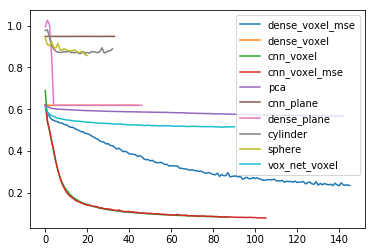

In [26]:
import csv
import pandas as pd

results = [
    "results_dense_voxel_mse.csv",
    "results_dense_voxel.csv",
    "results_cnn_voxel.csv",
    "results_cnn_voxel_mse.csv",
    "results_pca.csv",
    "results_cnn_plane.csv",
    "results_dense_plane.csv",
    "results_cylinder.csv",
    "results_sphere.csv",
    "results_vox_net_voxel.csv"
    ]

all_results_list = dict()
handles = list()
for result in  results:
    name = result.replace("results_", "").split(".")[0]
    results_dict = {
        "loss": list(), 
        "val_loss": list()
    }
    with open(result, newline='') as csvfile:
        for num, row in enumerate(csv.reader(csvfile, delimiter=',', quotechar='|')):
            if num == 0:
                continue
            results_dict["loss"].append(float(row[1]))
            results_dict["val_loss"].append(float(row[3]))
    all_results_list[name] = pd.DataFrame.from_dict(results_dict)
    p = plt.plot(all_results_list[name]["val_loss"], label=name)
    plt.legend()

7) CNN exploration: Examples of filters generated by networks:

<Figure size 8000x800 with 0 Axes>

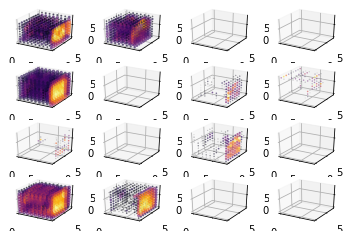

In [41]:
def plot_voxels_2(nvoxels, ax, resolution=9, point_size=10, alpha=1):
    xs = list()
    ys = list()
    zs = list()
    sizes = list()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xs.append(x)
                ys.append(y)
                zs.append(z)
                sizes.append(point_size*(nvoxels[x, z, y, 0] )**2)
    ax.scatter(xs, ys, zs, s=sizes, c=sizes, alpha=alpha, cmap='inferno', marker="o")

fig = plt.figure(figsize=(100, 10), dpi= 80)
#ax = fig.add_subplot(111, projection='3d')
fig, ((ax1, ax2, ax3,  ax4), 
      (ax5, ax6, ax7, ax8),
     (ax9, ax10, ax11, ax12),
     (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, subplot_kw=dict(projection='3d'))

axs = (ax1, ax2, ax3,  ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)
for i in range(16):
    #plt.matshow(activations[0][0, :, :, i], cmap='viridis')
    plot_voxels_2(activations[0][0][:, :, :, i].reshape((9, 9, 9, 1)), axs[i], resolution=9, point_size=1, alpha=.5)

<Figure size 8000x800 with 0 Axes>

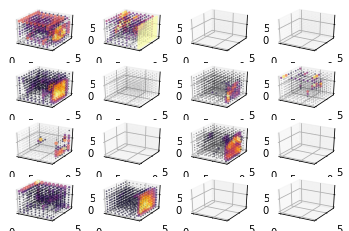

In [42]:
fig = plt.figure(figsize=(100, 10), dpi= 80)
#ax = fig.add_subplot(111, projection='3d')
fig, ((ax1, ax2, ax3,  ax4), 
      (ax5, ax6, ax7, ax8),
     (ax9, ax10, ax11, ax12),
     (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, subplot_kw=dict(projection='3d'))

axs = (ax1, ax2, ax3,  ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)
for i in range(16):
    #plt.matshow(activations[0][0, :, :, i], cmap='viridis')
    plot_voxels_2(activations[1][0][:, :, :, i].reshape((9, 9, 9, 1)), axs[i], resolution=9, point_size=1, alpha=.5)

<Figure size 8000x800 with 0 Axes>

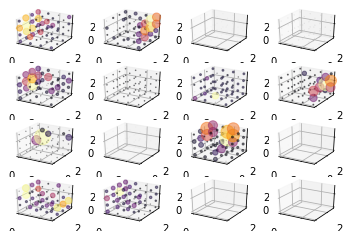

In [43]:
fig = plt.figure(figsize=(100, 10), dpi= 80)
#ax = fig.add_subplot(111, projection='3d')
fig, ((ax1, ax2, ax3,  ax4), 
      (ax5, ax6, ax7, ax8),
     (ax9, ax10, ax11, ax12),
     (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, subplot_kw=dict(projection='3d'))
axs = (ax1, ax2, ax3,  ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)
for i in range(16):
    #plt.matshow(activations[0][0, :, :, i], cmap='viridis')
    plot_voxels_2(activations[2][0][:, :, :, i].reshape((4, 4, 4, 1)), axs[i], resolution=4, point_size=30, alpha=.5)

<Figure size 8000x800 with 0 Axes>

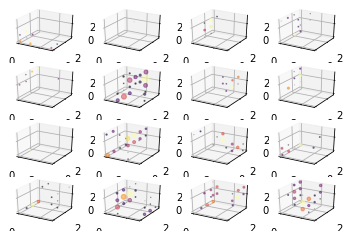

In [44]:
fig = plt.figure(figsize=(100, 10), dpi= 80)
#ax = fig.add_subplot(111, projection='3d')
fig, ((ax1, ax2, ax3,  ax4), 
      (ax5, ax6, ax7, ax8),
     (ax9, ax10, ax11, ax12),
     (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, subplot_kw=dict(projection='3d'))
def plot_voxels_2(nvoxels, ax, resolution=9, point_size=10, alpha=1):
    xs = list()
    ys = list()
    zs = list()
    sizes = list()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xs.append(x)
                ys.append(y)
                zs.append(z)
                sizes.append(point_size*(nvoxels[x, z, y, 0] )**2)
    ax.scatter(xs, ys, zs, s=sizes, c=sizes, alpha=alpha, cmap='inferno', marker="o")
axs = (ax1, ax2, ax3,  ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)
for i in range(16):
    #plt.matshow(activations[0][0, :, :, i], cmap='viridis')
    plot_voxels_2(activations[4][0][:, :, :, i].reshape((4, 4, 4, 1)), axs[i], resolution=4, point_size=1, alpha=.5)

cnn_voxel and cnn_voxel_mse are by far the best performing networks, so they will be trained more and usedlater.

In [27]:
model_cnn_voxels = keras.models.load_model(os.path.join("models", 'cnn_voxel.model'), custom_objects={'rmse_360_2': rmse_360_2})  
model_cnn_voxels.fit_generator(generator=voxel_training_generator, validation_data=voxel_validation_generator,
                               epochs=500, callbacks=[checkpoint_cnn_voxel, store_result_cnn_voxel, reduce_lr])
model_cnn_voxels.save(os.path.join("models", 'cnn_voxel.model'))

model_cnn_voxels_mse = keras.models.load_model(os.path.join("models", 'cnn_voxel_mse.model'), custom_objects={'rmse_360_2': rmse_360_2})  
model_cnn_voxels_mse.fit_generator(generator=voxel_training_generator, validation_data=voxel_validation_generator,
                               epochs=500, callbacks=[checkpoint_cnn_voxel, store_result_cnn_voxel, reduce_lr])
model_cnn_voxels_mse.save(os.path.join("models", 'cnn_voxel_mse.model'))

Epoch 1/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0842 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0842 - mean_absolute_percentage_error: 3926172.4906 - cosine_proximity: -0.9853 - val_loss: 0.0550 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0550 - val_mean_absolute_percentage_error: 2395817.9173 - val_cosine_proximity: -0.9951

Epoch 00001: val_loss improved from 0.05834 to 0.05499, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 2/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0837 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0837 - mean_absolute_percentage_error: 3958519.1612 - cosine_proximity: -0.9857 - val_loss: 0.0599 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0599 - val_mean_absolute_percentage_error: 2840013.7218 - val_cosine_proximity: -0.9947

Epoch 00002: val_loss did not improve from 0.05499
Epoch 3/500
421/421 [==============================] - 8s 20ms/step - loss:

421/421 [==============================] - 8s 20ms/step - loss: 0.0792 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0792 - mean_absolute_percentage_error: 3687899.3397 - cosine_proximity: -0.9874 - val_loss: 0.0596 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0596 - val_mean_absolute_percentage_error: 2541492.7258 - val_cosine_proximity: -0.9943

Epoch 00019: val_loss did not improve from 0.05288
Epoch 20/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0797 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0797 - mean_absolute_percentage_error: 3623834.9252 - cosine_proximity: -0.9873 - val_loss: 0.0570 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0570 - val_mean_absolute_percentage_error: 2584579.2686 - val_cosine_proximity: -0.9947

Epoch 00020: val_loss did not improve from 0.05288
Epoch 21/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0790 - mean_squared_error: 0.0143 - mean_absolute_error:

421/421 [==============================] - 9s 20ms/step - loss: 0.0768 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0768 - mean_absolute_percentage_error: 3576477.2398 - cosine_proximity: -0.9883 - val_loss: 0.0521 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0521 - val_mean_absolute_percentage_error: 2136286.2560 - val_cosine_proximity: -0.9960

Epoch 00037: val_loss did not improve from 0.05172
Epoch 38/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0758 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 3389758.3528 - cosine_proximity: -0.9887 - val_loss: 0.0551 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0551 - val_mean_absolute_percentage_error: 2395130.5726 - val_cosine_proximity: -0.9955

Epoch 00038: val_loss did not improve from 0.05172
Epoch 39/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0757 - mean_squared_error: 0.0130 - mean_absolute_error:

421/421 [==============================] - 8s 20ms/step - loss: 0.0740 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0740 - mean_absolute_percentage_error: 3379185.3514 - cosine_proximity: -0.9891 - val_loss: 0.0513 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0513 - val_mean_absolute_percentage_error: 1918865.3165 - val_cosine_proximity: -0.9959

Epoch 00055: val_loss did not improve from 0.04906
Epoch 56/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0733 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0733 - mean_absolute_percentage_error: 3292756.0327 - cosine_proximity: -0.9893 - val_loss: 0.0553 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0553 - val_mean_absolute_percentage_error: 2160878.8145 - val_cosine_proximity: -0.9951

Epoch 00056: val_loss did not improve from 0.04906
Epoch 57/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0735 - mean_squared_error: 0.0124 - mean_absolute_error:

421/421 [==============================] - 8s 19ms/step - loss: 0.0716 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0716 - mean_absolute_percentage_error: 3236747.6946 - cosine_proximity: -0.9899 - val_loss: 0.0507 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0507 - val_mean_absolute_percentage_error: 1874588.3306 - val_cosine_proximity: -0.9964

Epoch 00073: val_loss did not improve from 0.04777
Epoch 74/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0715 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0715 - mean_absolute_percentage_error: 3224467.3707 - cosine_proximity: -0.9897 - val_loss: 0.0507 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0507 - val_mean_absolute_percentage_error: 2182449.5927 - val_cosine_proximity: -0.9960

Epoch 00074: val_loss did not improve from 0.04777
Epoch 75/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0713 - mean_squared_error: 0.0116 - mean_absolute_error:


Epoch 00091: val_loss did not improve from 0.04573
Epoch 92/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0702 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0702 - mean_absolute_percentage_error: 3092362.3720 - cosine_proximity: -0.9902 - val_loss: 0.0493 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0493 - val_mean_absolute_percentage_error: 1916286.6915 - val_cosine_proximity: -0.9965

Epoch 00092: val_loss did not improve from 0.04573
Epoch 93/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0698 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0698 - mean_absolute_percentage_error: 3097704.9710 - cosine_proximity: -0.9903 - val_loss: 0.0505 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0505 - val_mean_absolute_percentage_error: 1869133.9940 - val_cosine_proximity: -0.9966

Epoch 00093: val_loss did not improve from 0.04573
Epoch 94/500
421/421 [==============================] - 8s 20ms/step -

421/421 [==============================] - 8s 20ms/step - loss: 0.0688 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0688 - mean_absolute_percentage_error: 2992811.2329 - cosine_proximity: -0.9907 - val_loss: 0.0485 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0485 - val_mean_absolute_percentage_error: 1986295.5766 - val_cosine_proximity: -0.9967

Epoch 00110: val_loss did not improve from 0.04521
Epoch 111/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0688 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0688 - mean_absolute_percentage_error: 3016193.4566 - cosine_proximity: -0.9906 - val_loss: 0.0451 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0451 - val_mean_absolute_percentage_error: 1903494.4032 - val_cosine_proximity: -0.9970

Epoch 00111: val_loss improved from 0.04521 to 0.04508, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 112/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0688 

421/421 [==============================] - 8s 19ms/step - loss: 0.0681 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0681 - mean_absolute_percentage_error: 3008421.5904 - cosine_proximity: -0.9908 - val_loss: 0.0449 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0449 - val_mean_absolute_percentage_error: 1594516.5444 - val_cosine_proximity: -0.9968

Epoch 00128: val_loss did not improve from 0.04480
Epoch 129/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0674 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0674 - mean_absolute_percentage_error: 2984831.9082 - cosine_proximity: -0.9911 - val_loss: 0.0462 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0462 - val_mean_absolute_percentage_error: 1772669.8851 - val_cosine_proximity: -0.9969

Epoch 00129: val_loss did not improve from 0.04480
Epoch 130/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0678 - mean_squared_error: 0.0105 - mean_absolute_erro

421/421 [==============================] - 8s 19ms/step - loss: 0.0667 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0667 - mean_absolute_percentage_error: 2893811.8034 - cosine_proximity: -0.9912 - val_loss: 0.0428 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 1616810.1845 - val_cosine_proximity: -0.9972

Epoch 00146: val_loss improved from 0.04298 to 0.04275, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 147/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0666 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0666 - mean_absolute_percentage_error: 2973694.3261 - cosine_proximity: -0.9912 - val_loss: 0.0448 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0448 - val_mean_absolute_percentage_error: 1788786.1169 - val_cosine_proximity: -0.9971

Epoch 00147: val_loss did not improve from 0.04275
Epoch 148/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0668 

421/421 [==============================] - 8s 20ms/step - loss: 0.0660 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0660 - mean_absolute_percentage_error: 2904855.8637 - cosine_proximity: -0.9913 - val_loss: 0.0461 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0461 - val_mean_absolute_percentage_error: 1631649.3921 - val_cosine_proximity: -0.9972

Epoch 00164: val_loss did not improve from 0.04224
Epoch 165/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0655 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0655 - mean_absolute_percentage_error: 2791086.5549 - cosine_proximity: -0.9914 - val_loss: 0.0411 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0411 - val_mean_absolute_percentage_error: 1792468.5706 - val_cosine_proximity: -0.9974

Epoch 00165: val_loss improved from 0.04224 to 0.04110, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 166/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0656 

421/421 [==============================] - 8s 20ms/step - loss: 0.0648 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0648 - mean_absolute_percentage_error: 2739586.2393 - cosine_proximity: -0.9918 - val_loss: 0.0430 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0430 - val_mean_absolute_percentage_error: 1566632.4536 - val_cosine_proximity: -0.9974

Epoch 00182: val_loss did not improve from 0.04100
Epoch 183/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0649 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0649 - mean_absolute_percentage_error: 2819672.1161 - cosine_proximity: -0.9918 - val_loss: 0.0438 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0438 - val_mean_absolute_percentage_error: 1806920.0474 - val_cosine_proximity: -0.9972

Epoch 00183: val_loss did not improve from 0.04100
Epoch 184/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0647 - mean_squared_error: 0.0096 - mean_absolute_erro

421/421 [==============================] - 8s 20ms/step - loss: 0.0642 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 2784215.3499 - cosine_proximity: -0.9919 - val_loss: 0.0468 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0468 - val_mean_absolute_percentage_error: 1755686.9012 - val_cosine_proximity: -0.9965

Epoch 00200: val_loss did not improve from 0.03930
Epoch 201/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0638 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0638 - mean_absolute_percentage_error: 2746659.6127 - cosine_proximity: -0.9920 - val_loss: 0.0404 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0404 - val_mean_absolute_percentage_error: 1571287.5060 - val_cosine_proximity: -0.9975

Epoch 00201: val_loss did not improve from 0.03930
Epoch 202/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0643 - mean_squared_error: 0.0095 - mean_absolute_erro


Epoch 00218: val_loss did not improve from 0.03930
Epoch 219/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0641 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 2683950.9927 - cosine_proximity: -0.9919 - val_loss: 0.0437 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0437 - val_mean_absolute_percentage_error: 1873083.9012 - val_cosine_proximity: -0.9972

Epoch 00219: val_loss did not improve from 0.03930
Epoch 220/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0640 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 2737923.7066 - cosine_proximity: -0.9920 - val_loss: 0.0477 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0477 - val_mean_absolute_percentage_error: 1633512.1371 - val_cosine_proximity: -0.9973

Epoch 00220: val_loss did not improve from 0.03930
Epoch 221/500
421/421 [==============================] - 9s 20ms/ste


Epoch 00237: val_loss did not improve from 0.03930
Epoch 238/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0632 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 2639125.8799 - cosine_proximity: -0.9922 - val_loss: 0.0443 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 1637200.0131 - val_cosine_proximity: -0.9973

Epoch 00238: val_loss did not improve from 0.03930
Epoch 239/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0632 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 2706241.5646 - cosine_proximity: -0.9922 - val_loss: 0.0431 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0431 - val_mean_absolute_percentage_error: 1601023.0665 - val_cosine_proximity: -0.9971

Epoch 00239: val_loss did not improve from 0.03930
Epoch 240/500
421/421 [==============================] - 9s 21ms/ste

421/421 [==============================] - 8s 20ms/step - loss: 0.0623 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0623 - mean_absolute_percentage_error: 2646607.8032 - cosine_proximity: -0.9925 - val_loss: 0.0415 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 1412020.5847 - val_cosine_proximity: -0.9977

Epoch 00256: val_loss did not improve from 0.03768
Epoch 257/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0625 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0625 - mean_absolute_percentage_error: 2569657.5769 - cosine_proximity: -0.9923 - val_loss: 0.0417 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 1540218.8125 - val_cosine_proximity: -0.9975

Epoch 00257: val_loss did not improve from 0.03768
Epoch 258/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0621 - mean_squared_error: 0.0089 - mean_absolute_erro


Epoch 00274: val_loss did not improve from 0.03726
Epoch 275/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0621 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0621 - mean_absolute_percentage_error: 2686703.4999 - cosine_proximity: -0.9925 - val_loss: 0.0381 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0381 - val_mean_absolute_percentage_error: 1382286.5222 - val_cosine_proximity: -0.9978

Epoch 00275: val_loss did not improve from 0.03726
Epoch 276/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0621 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0621 - mean_absolute_percentage_error: 2636949.8402 - cosine_proximity: -0.9924 - val_loss: 0.0432 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0432 - val_mean_absolute_percentage_error: 1669611.3498 - val_cosine_proximity: -0.9973

Epoch 00276: val_loss did not improve from 0.03726
Epoch 277/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00293: val_loss did not improve from 0.03726
Epoch 294/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0614 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0614 - mean_absolute_percentage_error: 2537757.5021 - cosine_proximity: -0.9925 - val_loss: 0.0400 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0400 - val_mean_absolute_percentage_error: 1368071.4839 - val_cosine_proximity: -0.9977

Epoch 00294: val_loss did not improve from 0.03726
Epoch 295/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0618 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0618 - mean_absolute_percentage_error: 2657022.1220 - cosine_proximity: -0.9925 - val_loss: 0.0457 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0457 - val_mean_absolute_percentage_error: 1663169.6351 - val_cosine_proximity: -0.9974

Epoch 00295: val_loss did not improve from 0.03726
Epoch 296/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00312: val_loss improved from 0.03726 to 0.03718, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 313/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0613 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0613 - mean_absolute_percentage_error: 2553027.2456 - cosine_proximity: -0.9926 - val_loss: 0.0404 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0404 - val_mean_absolute_percentage_error: 1685921.0000 - val_cosine_proximity: -0.9976

Epoch 00313: val_loss did not improve from 0.03718
Epoch 314/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0611 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0611 - mean_absolute_percentage_error: 2558121.4627 - cosine_proximity: -0.9927 - val_loss: 0.0436 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0436 - val_mean_absolute_percentage_error: 1551651.2722 - val_cosine_proximity: -0.9974

Epoch 00314: val_loss did not improve from 0.03718
Epoch 315/500
421/4

421/421 [==============================] - 8s 20ms/step - loss: 0.0611 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0611 - mean_absolute_percentage_error: 2577684.9408 - cosine_proximity: -0.9927 - val_loss: 0.0393 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0393 - val_mean_absolute_percentage_error: 1520309.9083 - val_cosine_proximity: -0.9977

Epoch 00331: val_loss did not improve from 0.03514
Epoch 332/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0611 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0611 - mean_absolute_percentage_error: 2552116.7418 - cosine_proximity: -0.9927 - val_loss: 0.0374 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0374 - val_mean_absolute_percentage_error: 1420915.0151 - val_cosine_proximity: -0.9979

Epoch 00332: val_loss did not improve from 0.03514
Epoch 333/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0608 - mean_squared_error: 0.0086 - mean_absolute_erro


Epoch 00349: val_loss did not improve from 0.03514
Epoch 350/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0610 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0610 - mean_absolute_percentage_error: 2587925.1311 - cosine_proximity: -0.9927 - val_loss: 0.0348 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0348 - val_mean_absolute_percentage_error: 1323134.0590 - val_cosine_proximity: -0.9981

Epoch 00350: val_loss improved from 0.03514 to 0.03477, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 351/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0609 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0609 - mean_absolute_percentage_error: 2513956.1511 - cosine_proximity: -0.9926 - val_loss: 0.0414 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 1404021.0524 - val_cosine_proximity: -0.9975

Epoch 00351: val_loss did not improve from 0.03477
Epoch 352/500
421/4

421/421 [==============================] - 8s 20ms/step - loss: 0.0601 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0601 - mean_absolute_percentage_error: 2538010.0809 - cosine_proximity: -0.9928 - val_loss: 0.0352 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0352 - val_mean_absolute_percentage_error: 1480456.2379 - val_cosine_proximity: -0.9981

Epoch 00368: val_loss did not improve from 0.03477
Epoch 369/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0604 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0604 - mean_absolute_percentage_error: 2564324.1799 - cosine_proximity: -0.9929 - val_loss: 0.0425 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0425 - val_mean_absolute_percentage_error: 1538238.7540 - val_cosine_proximity: -0.9977

Epoch 00369: val_loss did not improve from 0.03477
Epoch 370/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0604 - mean_squared_error: 0.0083 - mean_absolute_erro


Epoch 00386: val_loss did not improve from 0.03477
Epoch 387/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0600 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0600 - mean_absolute_percentage_error: 2499595.2640 - cosine_proximity: -0.9928 - val_loss: 0.0385 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0385 - val_mean_absolute_percentage_error: 1422924.2984 - val_cosine_proximity: -0.9979

Epoch 00387: val_loss did not improve from 0.03477
Epoch 388/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0600 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0600 - mean_absolute_percentage_error: 2511062.6318 - cosine_proximity: -0.9929 - val_loss: 0.0429 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0429 - val_mean_absolute_percentage_error: 1406160.1008 - val_cosine_proximity: -0.9977

Epoch 00388: val_loss did not improve from 0.03477
Epoch 389/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00405: val_loss did not improve from 0.03477
Epoch 406/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0597 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0597 - mean_absolute_percentage_error: 2560701.4558 - cosine_proximity: -0.9930 - val_loss: 0.0388 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0388 - val_mean_absolute_percentage_error: 1421540.7510 - val_cosine_proximity: -0.9981

Epoch 00406: val_loss did not improve from 0.03477
Epoch 407/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0593 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0593 - mean_absolute_percentage_error: 2527881.4200 - cosine_proximity: -0.9931 - val_loss: 0.0375 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0375 - val_mean_absolute_percentage_error: 1588025.4728 - val_cosine_proximity: -0.9979

Epoch 00407: val_loss did not improve from 0.03477
Epoch 408/500
421/421 [==============================] - 9s 20ms/ste

421/421 [==============================] - 8s 20ms/step - loss: 0.0594 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0594 - mean_absolute_percentage_error: 2468318.5310 - cosine_proximity: -0.9931 - val_loss: 0.0421 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 1441387.4617 - val_cosine_proximity: -0.9978

Epoch 00424: val_loss did not improve from 0.03421
Epoch 425/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0595 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0595 - mean_absolute_percentage_error: 2523233.9382 - cosine_proximity: -0.9929 - val_loss: 0.0379 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0379 - val_mean_absolute_percentage_error: 1522604.3226 - val_cosine_proximity: -0.9980

Epoch 00425: val_loss did not improve from 0.03421
Epoch 426/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0593 - mean_squared_error: 0.0082 - mean_absolute_erro


Epoch 00442: val_loss did not improve from 0.03421
Epoch 443/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0599 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0599 - mean_absolute_percentage_error: 2500477.6135 - cosine_proximity: -0.9929 - val_loss: 0.0385 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0385 - val_mean_absolute_percentage_error: 1557895.1633 - val_cosine_proximity: -0.9980

Epoch 00443: val_loss did not improve from 0.03421
Epoch 444/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0591 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0591 - mean_absolute_percentage_error: 2458454.1017 - cosine_proximity: -0.9932 - val_loss: 0.0362 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0362 - val_mean_absolute_percentage_error: 1438723.6935 - val_cosine_proximity: -0.9981

Epoch 00444: val_loss did not improve from 0.03421
Epoch 445/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00461: val_loss did not improve from 0.03421
Epoch 462/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0592 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0592 - mean_absolute_percentage_error: 2440009.0910 - cosine_proximity: -0.9931 - val_loss: 0.0383 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0383 - val_mean_absolute_percentage_error: 1373211.0544 - val_cosine_proximity: -0.9979

Epoch 00462: val_loss did not improve from 0.03421
Epoch 463/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0590 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0590 - mean_absolute_percentage_error: 2411418.2934 - cosine_proximity: -0.9932 - val_loss: 0.0350 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0350 - val_mean_absolute_percentage_error: 1417489.5121 - val_cosine_proximity: -0.9983

Epoch 00463: val_loss did not improve from 0.03421
Epoch 464/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00480: val_loss did not improve from 0.03421
Epoch 481/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0587 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0587 - mean_absolute_percentage_error: 2452793.4337 - cosine_proximity: -0.9933 - val_loss: 0.0393 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0393 - val_mean_absolute_percentage_error: 1375903.9859 - val_cosine_proximity: -0.9977

Epoch 00481: val_loss did not improve from 0.03421
Epoch 482/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0587 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0587 - mean_absolute_percentage_error: 2443464.6938 - cosine_proximity: -0.9933 - val_loss: 0.0397 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0397 - val_mean_absolute_percentage_error: 1395450.9839 - val_cosine_proximity: -0.9979

Epoch 00482: val_loss did not improve from 0.03421
Epoch 483/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00499: val_loss did not improve from 0.03421
Epoch 500/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0577 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0577 - mean_absolute_percentage_error: 2452458.7459 - cosine_proximity: -0.9936 - val_loss: 0.0369 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0369 - val_mean_absolute_percentage_error: 1208763.5859 - val_cosine_proximity: -0.9981

Epoch 00500: val_loss did not improve from 0.03421
Epoch 1/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0803 - mean_absolute_percentage_error: 4843413.9568 - cosine_proximity: -0.9897 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0580 - val_mean_absolute_percentage_error: 2995830.0302 - val_cosine_proximity: -0.9957

Epoch 00001: val_loss improved from 0.03421 to 0.00595, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 2/500
421/421 [

421/421 [==============================] - 8s 20ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0773 - mean_absolute_percentage_error: 4547385.9722 - cosine_proximity: -0.9905 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0624 - val_mean_absolute_percentage_error: 3505146.7117 - val_cosine_proximity: -0.9946

Epoch 00018: val_loss did not improve from 0.00540
Epoch 19/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0782 - mean_absolute_percentage_error: 4806910.6609 - cosine_proximity: -0.9903 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0560 - val_mean_absolute_percentage_error: 2790259.1351 - val_cosine_proximity: -0.9959

Epoch 00019: val_loss did not improve from 0.00540
Epoch 20/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error:

421/421 [==============================] - 8s 20ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0734 - mean_absolute_percentage_error: 4239757.8783 - cosine_proximity: -0.9915 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0538 - val_mean_absolute_percentage_error: 2650064.0444 - val_cosine_proximity: -0.9961

Epoch 00036: val_loss did not improve from 0.00443
Epoch 37/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0742 - mean_absolute_percentage_error: 4363439.1393 - cosine_proximity: -0.9914 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0549 - val_mean_absolute_percentage_error: 2772082.0020 - val_cosine_proximity: -0.9961

Epoch 00037: val_loss did not improve from 0.00443
Epoch 38/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error:


Epoch 00054: val_loss did not improve from 0.00443
Epoch 55/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 4112417.5453 - cosine_proximity: -0.9920 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0491 - val_mean_absolute_percentage_error: 2587675.3750 - val_cosine_proximity: -0.9967

Epoch 00055: val_loss improved from 0.00443 to 0.00420, saving model to /tmp/weights_cnn_voxel.hdf5
Epoch 56/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 4157787.2196 - cosine_proximity: -0.9918 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0505 - val_mean_absolute_percentage_error: 2419954.2258 - val_cosine_proximity: -0.9969

Epoch 00056: val_loss did not improve from 0.00420
Epoch 57/500
421/421 

421/421 [==============================] - 9s 22ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0696 - mean_absolute_percentage_error: 4055838.0634 - cosine_proximity: -0.9925 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0508 - val_mean_absolute_percentage_error: 2397519.0766 - val_cosine_proximity: -0.9967

Epoch 00073: val_loss did not improve from 0.00401
Epoch 74/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0690 - mean_absolute_percentage_error: 3969515.9963 - cosine_proximity: -0.9926 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0510 - val_mean_absolute_percentage_error: 2518384.1290 - val_cosine_proximity: -0.9966

Epoch 00074: val_loss did not improve from 0.00401
Epoch 75/500
421/421 [==============================] - 9s 22ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error:

421/421 [==============================] - 10s 23ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0688 - mean_absolute_percentage_error: 4002814.0257 - cosine_proximity: -0.9925 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0483 - val_mean_absolute_percentage_error: 2381880.5746 - val_cosine_proximity: -0.9971

Epoch 00091: val_loss did not improve from 0.00375
Epoch 92/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0685 - mean_absolute_percentage_error: 3913466.0834 - cosine_proximity: -0.9928 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0471 - val_mean_absolute_percentage_error: 2102089.1673 - val_cosine_proximity: -0.9973

Epoch 00092: val_loss did not improve from 0.00375
Epoch 93/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error


Epoch 00109: val_loss did not improve from 0.00364
Epoch 110/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0673 - mean_absolute_percentage_error: 3930057.3019 - cosine_proximity: -0.9929 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0477 - val_mean_absolute_percentage_error: 2258633.6431 - val_cosine_proximity: -0.9972

Epoch 00110: val_loss did not improve from 0.00364
Epoch 111/500
421/421 [==============================] - 9s 22ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0671 - mean_absolute_percentage_error: 3769494.7769 - cosine_proximity: -0.9930 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0493 - val_mean_absolute_percentage_error: 2358464.4153 - val_cosine_proximity: -0.9971

Epoch 00111: val_loss did not improve from 0.00364
Epoch 112/500
421/421 [==============================] - 8s 20ms/ste

421/421 [==============================] - 8s 19ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0662 - mean_absolute_percentage_error: 3797098.2838 - cosine_proximity: -0.9932 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0506 - val_mean_absolute_percentage_error: 2854021.9637 - val_cosine_proximity: -0.9965

Epoch 00128: val_loss did not improve from 0.00348
Epoch 129/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0663 - mean_absolute_percentage_error: 3813447.3735 - cosine_proximity: -0.9932 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0479 - val_mean_absolute_percentage_error: 2282794.8629 - val_cosine_proximity: -0.9973

Epoch 00129: val_loss did not improve from 0.00348
Epoch 130/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_erro

421/421 [==============================] - 9s 21ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0653 - mean_absolute_percentage_error: 3674610.0584 - cosine_proximity: -0.9934 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0474 - val_mean_absolute_percentage_error: 2453741.3750 - val_cosine_proximity: -0.9973

Epoch 00146: val_loss did not improve from 0.00324
Epoch 147/500
421/421 [==============================] - 9s 22ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0650 - mean_absolute_percentage_error: 3768370.8105 - cosine_proximity: -0.9935 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0482 - val_mean_absolute_percentage_error: 2180204.0948 - val_cosine_proximity: -0.9970

Epoch 00147: val_loss did not improve from 0.00324
Epoch 148/500
421/421 [==============================] - 9s 22ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_erro


Epoch 00164: val_loss did not improve from 0.00312
Epoch 165/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 3647746.4929 - cosine_proximity: -0.9936 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0455 - val_mean_absolute_percentage_error: 2064870.1976 - val_cosine_proximity: -0.9975

Epoch 00165: val_loss did not improve from 0.00312
Epoch 166/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 3628187.8860 - cosine_proximity: -0.9937 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0475 - val_mean_absolute_percentage_error: 2067535.9516 - val_cosine_proximity: -0.9973

Epoch 00166: val_loss did not improve from 0.00312
Epoch 167/500
421/421 [==============================] - 9s 21ms/ste


Epoch 00183: val_loss did not improve from 0.00312
Epoch 184/500
421/421 [==============================] - 9s 22ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 3663401.4277 - cosine_proximity: -0.9939 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0425 - val_mean_absolute_percentage_error: 1947255.8740 - val_cosine_proximity: -0.9976

Epoch 00184: val_loss did not improve from 0.00312
Epoch 185/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0639 - mean_absolute_percentage_error: 3533719.3115 - cosine_proximity: -0.9937 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0458 - val_mean_absolute_percentage_error: 1766658.6663 - val_cosine_proximity: -0.9977

Epoch 00185: val_loss did not improve from 0.00312
Epoch 186/500
421/421 [==============================] - 9s 22ms/ste

421/421 [==============================] - 8s 20ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 3519406.9906 - cosine_proximity: -0.9938 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 1964966.5242 - val_cosine_proximity: -0.9976

Epoch 00202: val_loss did not improve from 0.00307
Epoch 203/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 3562575.8727 - cosine_proximity: -0.9939 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0439 - val_mean_absolute_percentage_error: 1927228.9496 - val_cosine_proximity: -0.9977

Epoch 00203: val_loss did not improve from 0.00307
Epoch 204/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_erro


Epoch 00220: val_loss did not improve from 0.00306
Epoch 221/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 3566609.5779 - cosine_proximity: -0.9939 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0444 - val_mean_absolute_percentage_error: 2228818.8921 - val_cosine_proximity: -0.9976

Epoch 00221: val_loss did not improve from 0.00306
Epoch 222/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0622 - mean_absolute_percentage_error: 3516796.2341 - cosine_proximity: -0.9941 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0480 - val_mean_absolute_percentage_error: 2196646.5403 - val_cosine_proximity: -0.9976

Epoch 00222: val_loss did not improve from 0.00306
Epoch 223/500
421/421 [==============================] - 9s 20ms/ste

421/421 [==============================] - 9s 21ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0627 - mean_absolute_percentage_error: 3520175.0652 - cosine_proximity: -0.9939 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0449 - val_mean_absolute_percentage_error: 2087284.5766 - val_cosine_proximity: -0.9975

Epoch 00239: val_loss did not improve from 0.00279
Epoch 240/500
421/421 [==============================] - 9s 20ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0616 - mean_absolute_percentage_error: 3507623.3144 - cosine_proximity: -0.9942 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0475 - val_mean_absolute_percentage_error: 2075748.3528 - val_cosine_proximity: -0.9973

Epoch 00240: val_loss did not improve from 0.00279
Epoch 241/500
421/421 [==============================] - 9s 21ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_erro


Epoch 00257: val_loss did not improve from 0.00254
Epoch 258/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0615 - mean_absolute_percentage_error: 3434906.2294 - cosine_proximity: -0.9942 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0440 - val_mean_absolute_percentage_error: 1943467.4738 - val_cosine_proximity: -0.9978

Epoch 00258: val_loss did not improve from 0.00254
Epoch 259/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0613 - mean_absolute_percentage_error: 3446142.3132 - cosine_proximity: -0.9943 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0441 - val_mean_absolute_percentage_error: 2053844.4738 - val_cosine_proximity: -0.9978

Epoch 00259: val_loss did not improve from 0.00254
Epoch 260/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00276: val_loss did not improve from 0.00254
Epoch 277/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0607 - mean_absolute_percentage_error: 3414681.3877 - cosine_proximity: -0.9943 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0440 - val_mean_absolute_percentage_error: 2090169.5504 - val_cosine_proximity: -0.9976

Epoch 00277: val_loss did not improve from 0.00254
Epoch 278/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0610 - mean_absolute_percentage_error: 3360855.1630 - cosine_proximity: -0.9943 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0411 - val_mean_absolute_percentage_error: 1772087.2772 - val_cosine_proximity: -0.9979

Epoch 00278: val_loss did not improve from 0.00254
Epoch 279/500
421/421 [==============================] - 8s 19ms/ste


Epoch 00295: val_loss did not improve from 0.00254
Epoch 296/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0614 - mean_absolute_percentage_error: 3396873.0753 - cosine_proximity: -0.9941 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 1926117.4819 - val_cosine_proximity: -0.9980

Epoch 00296: val_loss did not improve from 0.00254
Epoch 297/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0606 - mean_absolute_percentage_error: 3332027.6816 - cosine_proximity: -0.9944 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0453 - val_mean_absolute_percentage_error: 2059822.5071 - val_cosine_proximity: -0.9977

Epoch 00297: val_loss did not improve from 0.00254
Epoch 298/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00314: val_loss did not improve from 0.00254
Epoch 315/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0602 - mean_absolute_percentage_error: 3431040.4647 - cosine_proximity: -0.9944 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0439 - val_mean_absolute_percentage_error: 1975362.5847 - val_cosine_proximity: -0.9974

Epoch 00315: val_loss did not improve from 0.00254
Epoch 316/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0604 - mean_absolute_percentage_error: 3370568.0687 - cosine_proximity: -0.9944 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 1757736.4405 - val_cosine_proximity: -0.9980

Epoch 00316: val_loss did not improve from 0.00254
Epoch 317/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00333: val_loss did not improve from 0.00254
Epoch 334/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0602 - mean_absolute_percentage_error: 3353590.5741 - cosine_proximity: -0.9945 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0445 - val_mean_absolute_percentage_error: 2330658.6008 - val_cosine_proximity: -0.9973

Epoch 00334: val_loss did not improve from 0.00254
Epoch 335/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0600 - mean_absolute_percentage_error: 3377957.2306 - cosine_proximity: -0.9945 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0452 - val_mean_absolute_percentage_error: 1941834.7177 - val_cosine_proximity: -0.9976

Epoch 00335: val_loss did not improve from 0.00254
Epoch 336/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00352: val_loss did not improve from 0.00254
Epoch 353/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0599 - mean_absolute_percentage_error: 3211598.6677 - cosine_proximity: -0.9945 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 1753959.6613 - val_cosine_proximity: -0.9979

Epoch 00353: val_loss did not improve from 0.00254
Epoch 354/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0597 - mean_absolute_percentage_error: 3309769.8587 - cosine_proximity: -0.9945 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0410 - val_mean_absolute_percentage_error: 1869643.5786 - val_cosine_proximity: -0.9980

Epoch 00354: val_loss did not improve from 0.00254
Epoch 355/500
421/421 [==============================] - 8s 20ms/ste

421/421 [==============================] - 8s 20ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0598 - mean_absolute_percentage_error: 3304078.8155 - cosine_proximity: -0.9945 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 1895880.6149 - val_cosine_proximity: -0.9979

Epoch 00371: val_loss did not improve from 0.00240
Epoch 372/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0594 - mean_absolute_percentage_error: 3359172.7883 - cosine_proximity: -0.9946 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0405 - val_mean_absolute_percentage_error: 1858612.6290 - val_cosine_proximity: -0.9981

Epoch 00372: val_loss did not improve from 0.00240
Epoch 373/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_erro


Epoch 00389: val_loss did not improve from 0.00240
Epoch 390/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0588 - mean_absolute_percentage_error: 3282802.8770 - cosine_proximity: -0.9947 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0469 - val_mean_absolute_percentage_error: 1921898.7238 - val_cosine_proximity: -0.9976

Epoch 00390: val_loss did not improve from 0.00240
Epoch 391/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0592 - mean_absolute_percentage_error: 3294099.5518 - cosine_proximity: -0.9946 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0397 - val_mean_absolute_percentage_error: 1741616.8448 - val_cosine_proximity: -0.9981

Epoch 00391: val_loss did not improve from 0.00240
Epoch 392/500
421/421 [==============================] - 8s 20ms/ste

421/421 [==============================] - 8s 20ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0590 - mean_absolute_percentage_error: 3242240.4823 - cosine_proximity: -0.9947 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 1967899.9244 - val_cosine_proximity: -0.9978

Epoch 00408: val_loss did not improve from 0.00239
Epoch 409/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0589 - mean_absolute_percentage_error: 3236586.2221 - cosine_proximity: -0.9947 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 1807160.0060 - val_cosine_proximity: -0.9979

Epoch 00409: val_loss did not improve from 0.00239
Epoch 410/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_erro


Epoch 00426: val_loss did not improve from 0.00239
Epoch 427/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0582 - mean_absolute_percentage_error: 3234563.1125 - cosine_proximity: -0.9948 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0410 - val_mean_absolute_percentage_error: 1974906.2036 - val_cosine_proximity: -0.9979

Epoch 00427: val_loss did not improve from 0.00239
Epoch 428/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0589 - mean_absolute_percentage_error: 3310393.3560 - cosine_proximity: -0.9946 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0408 - val_mean_absolute_percentage_error: 2010340.6573 - val_cosine_proximity: -0.9980

Epoch 00428: val_loss did not improve from 0.00239
Epoch 429/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00445: val_loss did not improve from 0.00239
Epoch 446/500
421/421 [==============================] - 8s 19ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0584 - mean_absolute_percentage_error: 3162293.6134 - cosine_proximity: -0.9947 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 1788132.5000 - val_cosine_proximity: -0.9980

Epoch 00446: val_loss did not improve from 0.00239
Epoch 447/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0581 - mean_absolute_percentage_error: 3201871.6587 - cosine_proximity: -0.9949 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 1794326.0927 - val_cosine_proximity: -0.9980

Epoch 00447: val_loss did not improve from 0.00239
Epoch 448/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00464: val_loss did not improve from 0.00239
Epoch 465/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0581 - mean_absolute_percentage_error: 3159120.0836 - cosine_proximity: -0.9948 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0403 - val_mean_absolute_percentage_error: 1619514.5464 - val_cosine_proximity: -0.9981

Epoch 00465: val_loss did not improve from 0.00239
Epoch 466/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0585 - mean_absolute_percentage_error: 3142708.7032 - cosine_proximity: -0.9948 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0404 - val_mean_absolute_percentage_error: 1711053.5060 - val_cosine_proximity: -0.9981

Epoch 00466: val_loss did not improve from 0.00239
Epoch 467/500
421/421 [==============================] - 8s 20ms/ste


Epoch 00483: val_loss did not improve from 0.00239
Epoch 484/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0576 - mean_absolute_percentage_error: 3129838.9672 - cosine_proximity: -0.9950 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0375 - val_mean_absolute_percentage_error: 1623294.0081 - val_cosine_proximity: -0.9982

Epoch 00484: val_loss did not improve from 0.00239
Epoch 485/500
421/421 [==============================] - 8s 20ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0578 - mean_absolute_percentage_error: 3178658.9361 - cosine_proximity: -0.9949 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0399 - val_mean_absolute_percentage_error: 1696649.7056 - val_cosine_proximity: -0.9981

Epoch 00485: val_loss did not improve from 0.00239
Epoch 486/500
421/421 [==============================] - 8s 20ms/ste